In [13]:
import pandas as pd
import numpy as np

# Import the CSV files and convert them back to numpy arrays
# Set the fault number and simulation run to match the exported files
FAULT_NUMBER = 2
SIM_RUN = 1

# Import each CSV file
X_INCONTROL_TRAIN_SELECTED_SCALED = pd.read_csv(
    f"data/exported_csv/X_INCONTROL_TRAIN_SELECTED_SCALED_fault_{FAULT_NUMBER}_sim_{SIM_RUN}.csv"
).values

X_INCONTROL_TEST_SELECTED_SCALED = pd.read_csv(
    f"data/exported_csv/X_INCONTROL_TEST_SELECTED_SCALED_fault_{FAULT_NUMBER}_sim_{SIM_RUN}.csv"
).values

X_OUT_OF_CONTROL_TRAIN_SELECTED_SCALED = pd.read_csv(
    f"data/exported_csv/X_OUT_OF_CONTROL_TRAIN_SELECTED_SCALED_fault_{FAULT_NUMBER}_sim_{SIM_RUN}.csv"
).values

X_OUT_OF_CONTROL_TEST_SELECTED_SCALED = pd.read_csv(
    f"data/exported_csv/X_OUT_OF_CONTROL_TEST_SELECTED_SCALED_fault_{FAULT_NUMBER}_sim_{SIM_RUN}.csv"
).values

# Verify the shapes match the original data
print("Imported In-control training data shape:", X_INCONTROL_TRAIN_SELECTED_SCALED.shape)
print("Imported In-control test data shape:", X_INCONTROL_TEST_SELECTED_SCALED.shape)
print("Imported Out-of-control training data shape:", X_OUT_OF_CONTROL_TRAIN_SELECTED_SCALED.shape)
print("Imported Out-of-control test data shape:", X_OUT_OF_CONTROL_TEST_SELECTED_SCALED.shape)

Imported In-control training data shape: (500, 52)
Imported In-control test data shape: (960, 52)
Imported Out-of-control training data shape: (500, 52)
Imported Out-of-control test data shape: (960, 52)


# Multivariate Relationship Discovery System

This notebook implements a novel approach to discover relationships between process variables using:
- Distributional boundaries at multiple sensitivity levels
- Co-occurrence tracking of boundary violations
- Time-lagged dependency detection
- Hierarchical boundary refinement
- Online anomaly detection

## Configuration

In [14]:
# Configuration System
from dataclasses import dataclass
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

@dataclass
class AnalysisConfig:
    """Configuration for multivariate relationship analysis"""
    
    # Sensitivity Levels (sigma multipliers)
    sensitive_sigma: float = 1.0  # Narrow boundaries
    medium_sigma: float = 1.5     # Medium boundaries
    large_sigma: float = 2.0      # Wide boundaries
    
    # Time Lag Analysis
    min_lag: int = 0
    max_lag: int = 10
    lag_step: int = 1
    
    # Reporting
    min_cooccurrence: int = 1  # Include all relationships by default
    
    # Variable names (for Tennessee Eastman Process)
    variable_names: List[str] = None
    
    def __post_init__(self):
        if self.variable_names is None:
            # Tennessee Eastman Process variable names
            self.variable_names = [
                f'xmeas_{i}' for i in range(1, 42)
            ] + [f'xmv_{i}' for i in range(1, 12)]
    
    @property
    def sensitivity_levels(self) -> Dict[str, float]:
        """Return sensitivity levels as a dictionary"""
        return {
            'Sensitive': self.sensitive_sigma,
            'Medium': self.medium_sigma,
            'Large': self.large_sigma
        }
    
    @property
    def lag_range(self) -> List[int]:
        """Return list of lags to analyze"""
        return list(range(self.min_lag, self.max_lag + 1, self.lag_step))

# Initialize configuration
config = AnalysisConfig()

print("Configuration initialized:")
print(f"  Sensitivity levels: {config.sensitivity_levels}")
print(f"  Lag range: {config.min_lag} to {config.max_lag} (step {config.lag_step})")
print(f"  Number of variables: {len(config.variable_names)}")
print(f"  Minimum co-occurrence threshold: {config.min_cooccurrence}")

Configuration initialized:
  Sensitivity levels: {'Sensitive': 1.0, 'Medium': 1.5, 'Large': 2.0}
  Lag range: 0 to 10 (step 1)
  Number of variables: 52
  Minimum co-occurrence threshold: 1


## Phase 1: Define Normal Operating Boundaries

Calculate mean and standard deviation for each variable, then define boundaries at multiple sensitivity levels.

In [15]:
class BoundaryCalculator:
    """Calculate normal operating boundaries at multiple sensitivity levels"""
    
    def __init__(self, config: AnalysisConfig):
        self.config = config
        self.means = None
        self.stds = None
        self.boundaries = {}
    
    def fit(self, data: np.ndarray):
        """
        Calculate boundaries from training data
        
        Args:
            data: Training data (n_samples, n_variables)
        """
        self.means = np.mean(data, axis=0)
        self.stds = np.std(data, axis=0)
        
        # Calculate boundaries for each sensitivity level
        for level_name, sigma in self.config.sensitivity_levels.items():
            lower = self.means - sigma * self.stds
            upper = self.means + sigma * self.stds
            self.boundaries[level_name] = {
                'lower': lower,
                'upper': upper,
                'sigma': sigma
            }
        
        return self
    
    def get_boundaries(self, level: str) -> Tuple[np.ndarray, np.ndarray]:
        """Get lower and upper boundaries for a sensitivity level"""
        bounds = self.boundaries[level]
        return bounds['lower'], bounds['upper']
    
    def summary(self):
        """Print summary of calculated boundaries"""
        n_vars = len(self.means)
        print(f"\nBoundary Summary for {n_vars} variables:")
        print("=" * 60)
        
        for level_name, bounds in self.boundaries.items():
            print(f"\n{level_name} Level (±{bounds['sigma']}σ):")
            print(f"  Example Variable 0:")
            print(f"    Mean: {self.means[0]:.4f}")
            print(f"    Std: {self.stds[0]:.4f}")
            print(f"    Lower bound: {bounds['lower'][0]:.4f}")
            print(f"    Upper bound: {bounds['upper'][0]:.4f}")

# Initialize and fit boundary calculator with in-control training data
boundary_calc = BoundaryCalculator(config)
boundary_calc.fit(X_INCONTROL_TRAIN_SELECTED_SCALED)
boundary_calc.summary()


Boundary Summary for 52 variables:

Sensitive Level (±1.0σ):
  Example Variable 0:
    Mean: -0.0422
    Std: 0.1982
    Lower bound: -0.2404
    Upper bound: 0.1560

Medium Level (±1.5σ):
  Example Variable 0:
    Mean: -0.0422
    Std: 0.1982
    Lower bound: -0.3395
    Upper bound: 0.2552

Large Level (±2.0σ):
  Example Variable 0:
    Mean: -0.0422
    Std: 0.1982
    Lower bound: -0.4386
    Upper bound: 0.3543


## Phase 2: Detect Boundary Violations

For each timestep and variable, mark as "in excursion" (1) if value is outside boundaries, or "normal" (0) if inside.

In [16]:
class ViolationDetector:
    """Detect boundary violations for each variable and timestep"""
    
    def __init__(self, boundary_calc: BoundaryCalculator):
        self.boundary_calc = boundary_calc
        self.violations = {}
    
    def detect(self, data: np.ndarray, level: str) -> np.ndarray:
        """
        Detect boundary violations at a specific sensitivity level
        
        Args:
            data: Data to analyze (n_samples, n_variables)
            level: Sensitivity level ('Sensitive', 'Medium', 'Large')
        
        Returns:
            Binary matrix (n_samples, n_variables) where 1 = violation, 0 = normal
        """
        lower, upper = self.boundary_calc.get_boundaries(level)
        
        # Check if value is outside boundaries
        violations = (data < lower) | (data > upper)
        
        return violations.astype(int)
    
    def detect_all_levels(self, data: np.ndarray) -> Dict[str, np.ndarray]:
        """
        Detect violations at all sensitivity levels
        
        Returns:
            Dictionary mapping level name to violation matrix
        """
        self.violations = {}
        for level in self.boundary_calc.config.sensitivity_levels.keys():
            self.violations[level] = self.detect(data, level)
        
        return self.violations
    
    def summary(self, data: np.ndarray):
        """Print summary of violations detected"""
        n_samples, n_vars = data.shape
        
        print(f"\nViolation Summary for {n_samples} samples, {n_vars} variables:")
        print("=" * 60)
        
        for level, violations in self.violations.items():
            total_violations = np.sum(violations)
            violation_rate = total_violations / (n_samples * n_vars) * 100
            
            # Count variables with at least one violation
            vars_with_violations = np.sum(np.any(violations, axis=0))
            
            print(f"\n{level} Level:")
            print(f"  Total violations: {total_violations}")
            print(f"  Violation rate: {violation_rate:.2f}%")
            print(f"  Variables with violations: {vars_with_violations}/{n_vars}")
            print(f"  Avg violations per variable: {total_violations/n_vars:.1f}")

# Detect violations in test data at all sensitivity levels
violation_detector = ViolationDetector(boundary_calc)
test_violations = violation_detector.detect_all_levels(X_OUT_OF_CONTROL_TEST_SELECTED_SCALED)
violation_detector.summary(X_OUT_OF_CONTROL_TEST_SELECTED_SCALED)


Violation Summary for 960 samples, 52 variables:

Sensitive Level:
  Total violations: 29123
  Violation rate: 58.34%
  Variables with violations: 52/52
  Avg violations per variable: 560.1

Medium Level:
  Total violations: 21994
  Violation rate: 44.06%
  Variables with violations: 52/52
  Avg violations per variable: 423.0

Large Level:
  Total violations: 17008
  Violation rate: 34.07%
  Variables with violations: 52/52
  Avg violations per variable: 327.1


## Phase 3: Co-occurrence Analysis with Lag Detection

Count how many times two variables are both in excursion, both simultaneously and with time delays.

In [17]:
class CooccurrenceAnalyzer:
    """Analyze co-occurrence of boundary violations with lag detection"""
    
    def __init__(self, config: AnalysisConfig):
        self.config = config
        self.cooccurrence_matrices = {}
        self.lag_relationships = {}
    
    def compute_cooccurrence(self, violations: np.ndarray, lag: int = 0) -> np.ndarray:
        """
        Compute co-occurrence matrix for a given lag
        
        Args:
            violations: Binary violation matrix (n_samples, n_variables)
            lag: Time lag (0 for simultaneous, >0 for delayed)
        
        Returns:
            Co-occurrence matrix (n_variables, n_variables)
        """
        n_samples, n_vars = violations.shape
        cooccurrence = np.zeros((n_vars, n_vars))
        
        if lag == 0:
            # Simultaneous co-occurrence
            cooccurrence = violations.T @ violations
        else:
            # Lagged co-occurrence: var_i at time t, var_j at time t+lag
            if lag < n_samples:
                v1 = violations[:-lag, :]  # Variable i at time t
                v2 = violations[lag:, :]   # Variable j at time t+lag
                cooccurrence = v1.T @ v2
        
        return cooccurrence
    
    def analyze_all_lags(self, violations: np.ndarray, level: str):
        """
        Analyze co-occurrence across all configured lags for a sensitivity level
        
        Args:
            violations: Binary violation matrix
            level: Sensitivity level name
        """
        results = {}
        
        for lag in self.config.lag_range:
            cooccurrence = self.compute_cooccurrence(violations, lag)
            results[lag] = cooccurrence
        
        # Store results
        self.cooccurrence_matrices[level] = results
        
        # Extract relationships (variable pairs with non-zero co-occurrence)
        self.lag_relationships[level] = self._extract_relationships(results, level)
        
        return results
    
    def _extract_relationships(self, cooccurrence_dict: Dict[int, np.ndarray], 
                               level: str) -> Dict[int, List[Dict]]:
        """
        Extract variable relationships from co-occurrence matrices
        
        Returns:
            Dictionary mapping lag to list of relationships
        """
        relationships = {}
        n_vars = self.config.variable_names.__len__()
        
        for lag, matrix in cooccurrence_dict.items():
            lag_relationships = []
            
            for i in range(n_vars):
                for j in range(n_vars):
                    if i != j or lag > 0:  # Exclude self-loops at lag 0
                        count = matrix[i, j]
                        if count >= self.config.min_cooccurrence:
                            lag_relationships.append({
                                'var_i': i,
                                'var_j': j,
                                'var_i_name': self.config.variable_names[i],
                                'var_j_name': self.config.variable_names[j],
                                'count': int(count),
                                'lag': lag,
                                'level': level
                            })
            
            # Sort by count (descending)
            lag_relationships.sort(key=lambda x: x['count'], reverse=True)
            relationships[lag] = lag_relationships
        
        return relationships
    
    def get_dominant_lag(self, var_i: int, var_j: int, level: str) -> Tuple[int, int]:
        """
        Find the lag with maximum co-occurrence for a variable pair
        
        Returns:
            (dominant_lag, max_count)
        """
        if level not in self.cooccurrence_matrices:
            return (0, 0)
        
        max_count = 0
        dominant_lag = 0
        
        for lag, matrix in self.cooccurrence_matrices[level].items():
            count = matrix[var_i, var_j]
            if count > max_count:
                max_count = count
                dominant_lag = lag
        
        return (dominant_lag, int(max_count))
    
    def summary(self, level: str):
        """Print summary of relationships found at a sensitivity level"""
        if level not in self.lag_relationships:
            print(f"No analysis performed for {level} level")
            return
        
        print(f"\n{level} Level Relationship Summary:")
        print("=" * 60)
        
        total_relationships = 0
        for lag, relationships in self.lag_relationships[level].items():
            count = len(relationships)
            total_relationships += count
            if count > 0:
                print(f"  Lag {lag}: {count} relationships")
        
        print(f"\nTotal relationships: {total_relationships}")
        
        # Show top relationships at lag 0
        if 0 in self.lag_relationships[level]:
            lag0_rels = self.lag_relationships[level][0][:5]
            if lag0_rels:
                print(f"\nTop 5 simultaneous relationships (lag 0):")
                for rel in lag0_rels:
                    print(f"  {rel['var_i_name']} ↔ {rel['var_j_name']}: {rel['count']}")

# Initialize analyzer and run analysis for all sensitivity levels
cooccurrence_analyzer = CooccurrenceAnalyzer(config)

print("Analyzing co-occurrence patterns at all sensitivity levels...")
for level in config.sensitivity_levels.keys():
    violations = test_violations[level]
    cooccurrence_analyzer.analyze_all_lags(violations, level)
    cooccurrence_analyzer.summary(level)

Analyzing co-occurrence patterns at all sensitivity levels...

Sensitive Level Relationship Summary:
  Lag 0: 2652 relationships
  Lag 1: 2704 relationships
  Lag 2: 2704 relationships
  Lag 3: 2704 relationships
  Lag 4: 2704 relationships
  Lag 5: 2704 relationships
  Lag 6: 2704 relationships
  Lag 7: 2704 relationships
  Lag 8: 2704 relationships
  Lag 9: 2704 relationships
  Lag 10: 2704 relationships

Total relationships: 29692

Top 5 simultaneous relationships (lag 0):
  xmeas_10 ↔ xmv_6: 866
  xmv_6 ↔ xmeas_10: 866
  xmeas_10 ↔ xmeas_18: 833
  xmeas_18 ↔ xmeas_10: 833
  xmeas_18 ↔ xmv_6: 833

Medium Level Relationship Summary:
  Lag 0: 2648 relationships
  Lag 1: 2703 relationships
  Lag 2: 2703 relationships
  Lag 3: 2703 relationships
  Lag 4: 2703 relationships
  Lag 5: 2703 relationships
  Lag 6: 2704 relationships
  Lag 7: 2704 relationships
  Lag 8: 2704 relationships
  Lag 9: 2704 relationships
  Lag 10: 2704 relationships

Total relationships: 29683

Top 5 simultaneous 

## Phase 5: Comprehensive Reporting System

Generate detailed reports organized by sensitivity level and time lag, with relationship classification.

In [18]:
class RelationshipReporter:
    """Generate comprehensive reports of discovered relationships"""
    
    def __init__(self, config: AnalysisConfig, analyzer: CooccurrenceAnalyzer):
        self.config = config
        self.analyzer = analyzer
    
    def generate_full_report(self):
        """Generate complete relationship report"""
        print("\n" + "=" * 80)
        print("MULTIVARIATE RELATIONSHIP DISCOVERY REPORT")
        print("=" * 80)
        
        self._section1_by_sensitivity_and_lag()
        self._section2_summary_statistics()
        self._section3_variable_centric()
        self._section4_relationship_classification()
    
    def _section1_by_sensitivity_and_lag(self):
        """Section 1: Relationships organized by sensitivity level and lag"""
        print("\n\n" + "=" * 80)
        print("SECTION 1: RELATIONSHIPS BY SENSITIVITY LEVEL AND LAG")
        print("=" * 80)
        
        for level in ['Sensitive', 'Medium', 'Large']:
            if level not in self.analyzer.lag_relationships:
                continue
            
            sigma = self.config.sensitivity_levels[level]
            print(f"\n\nSENSITIVITY LEVEL: {level.upper()} (±{sigma}σ)")
            print("=" * 70)
            
            lag_rels = self.analyzer.lag_relationships[level]
            
            for lag in sorted(lag_rels.keys()):
                relationships = lag_rels[lag]
                
                if len(relationships) > 0:
                    lag_type = "Simultaneous" if lag == 0 else f"{lag}-timestep delay"
                    print(f"\nLAG {lag} ({lag_type}):")
                    print(f"  Total: {len(relationships)} relationships")
                    
                    # Show top 10 relationships for this lag
                    top_n = min(10, len(relationships))
                    for i, rel in enumerate(relationships[:top_n]):
                        arrow = "↔" if lag == 0 else "→"
                        print(f"    {rel['var_i_name']} {arrow} {rel['var_j_name']}: count={rel['count']}")
                    
                    if len(relationships) > top_n:
                        print(f"    ... and {len(relationships) - top_n} more")
    
    def _section2_summary_statistics(self):
        """Section 2: Summary statistics table"""
        print("\n\n" + "=" * 80)
        print("SECTION 2: SUMMARY STATISTICS")
        print("=" * 80)
        
        print(f"\n{'Sensitivity Level':<20} {'Total Rels':<15} {'Dominant Lag':<20}")
        print("-" * 55)
        
        for level in ['Sensitive', 'Medium', 'Large']:
            if level not in self.analyzer.lag_relationships:
                continue
            
            lag_rels = self.analyzer.lag_relationships[level]
            
            # Count total relationships
            total = sum(len(rels) for rels in lag_rels.values())
            
            # Find dominant lag (lag with most relationships)
            lag_counts = {lag: len(rels) for lag, rels in lag_rels.items()}
            if lag_counts:
                dominant_lag = max(lag_counts.items(), key=lambda x: x[1])
                dominant_str = f"Lag {dominant_lag[0]} ({dominant_lag[1]} rels)"
            else:
                dominant_str = "N/A"
            
            sigma = self.config.sensitivity_levels[level]
            level_str = f"{level} (±{sigma}σ)"
            
            print(f"{level_str:<20} {total:<15} {dominant_str:<20}")
        
        print("\n\nInterpretation Guide:")
        print("  • Relationships at ALL levels = robust (reliable for critical alarms)")
        print("  • Relationships only at sensitive level = early warning signals")
        print("  • More relationships at sensitive level = more subtle coordinated behaviors")
    
    def _section3_variable_centric(self):
        """Section 3: Variable-centric view"""
        print("\n\n" + "=" * 80)
        print("SECTION 3: VARIABLE-CENTRIC REPORT (Top 5 Variables by Connectivity)")
        print("=" * 80)
        
        # Count connections for each variable across all levels
        var_connections = defaultdict(lambda: {'Sensitive': 0, 'Medium': 0, 'Large': 0})
        
        for level in self.analyzer.lag_relationships:
            for lag, rels in self.analyzer.lag_relationships[level].items():
                for rel in rels:
                    var_connections[rel['var_i']][level] += 1
                    var_connections[rel['var_j']][level] += 1
        
        # Sort by total connections
        sorted_vars = sorted(
            var_connections.items(),
            key=lambda x: sum(x[1].values()),
            reverse=True
        )
        
        # Report top 5 variables
        for var_idx, connections in sorted_vars[:5]:
            var_name = self.config.variable_names[var_idx]
            total = sum(connections.values())
            
            print(f"\n\nVARIABLE: {var_name} (index {var_idx})")
            print("-" * 70)
            print(f"Total connections: {total}")
            
            for level in ['Sensitive', 'Medium', 'Large']:
                count = connections[level]
                print(f"\n{level} Level: {count} connections")
                
                if count > 0:
                    # Show outgoing relationships
                    outgoing = []
                    for lag, rels in self.analyzer.lag_relationships[level].items():
                        for rel in rels:
                            if rel['var_i'] == var_idx:
                                outgoing.append(rel)
                    
                    if outgoing:
                        print(f"  Influences (top 3):")
                        for rel in outgoing[:3]:
                            arrow = "→" if rel['lag'] > 0 else "↔"
                            print(f"    {arrow} {rel['var_j_name']} (lag {rel['lag']}, count {rel['count']})")
            
            # Robustness assessment
            if connections['Large'] > 0:
                print(f"\n  Relationship Robustness: HIGH (appears at all sensitivity levels)")
            elif connections['Medium'] > 0:
                print(f"\n  Relationship Robustness: MODERATE (appears at medium and sensitive)")
            else:
                print(f"\n  Relationship Robustness: LOW (only at sensitive level)")
    
    def _section4_relationship_classification(self):
        """Section 4: Classify relationships by robustness"""
        print("\n\n" + "=" * 80)
        print("SECTION 4: RELATIONSHIP CLASSIFICATION")
        print("=" * 80)
        
        # Build relationship index: (var_i, var_j, lag) -> {levels}
        relationship_index = defaultdict(set)
        
        for level in self.analyzer.lag_relationships:
            for lag, rels in self.analyzer.lag_relationships[level].items():
                for rel in rels:
                    key = (rel['var_i'], rel['var_j'], lag)
                    relationship_index[key].add(level)
        
        # Classify relationships
        robust = []
        moderate = []
        sensitive = []
        
        for key, levels in relationship_index.items():
            var_i, var_j, lag = key
            var_i_name = self.config.variable_names[var_i]
            var_j_name = self.config.variable_names[var_j]
            
            # Get counts from each level
            counts = {}
            for level in levels:
                for rel in self.analyzer.lag_relationships[level][lag]:
                    if rel['var_i'] == var_i and rel['var_j'] == var_j:
                        counts[level] = rel['count']
                        break
            
            relationship_info = {
                'var_i_name': var_i_name,
                'var_j_name': var_j_name,
                'lag': lag,
                'levels': levels,
                'counts': counts
            }
            
            if 'Large' in levels and 'Medium' in levels and 'Sensitive' in levels:
                robust.append(relationship_info)
            elif 'Sensitive' in levels and 'Medium' in levels:
                moderate.append(relationship_info)
            elif 'Sensitive' in levels:
                sensitive.append(relationship_info)
        
        # Report each category
        print(f"\n\n1. ROBUST RELATIONSHIPS (appear at all 3 sensitivity levels)")
        print("-" * 70)
        print(f"   Count: {len(robust)}")
        print("   Use case: Reliable for critical alarm triggers")
        if robust:
            print("\n   Top 5 examples:")
            for rel in robust[:5]:
                arrow = "→" if rel['lag'] > 0 else "↔"
                print(f"     {rel['var_i_name']} {arrow} {rel['var_j_name']} (lag {rel['lag']})")
                print(f"       Counts: Sensitive={rel['counts'].get('Sensitive', 0)}, " +
                      f"Medium={rel['counts'].get('Medium', 0)}, " +
                      f"Large={rel['counts'].get('Large', 0)}")
        
        print(f"\n\n2. MODERATE RELATIONSHIPS (appear at sensitive + medium levels)")
        print("-" * 70)
        print(f"   Count: {len(moderate)}")
        print("   Use case: Intermediate monitoring and investigation triggers")
        if moderate:
            print("\n   Top 5 examples:")
            for rel in moderate[:5]:
                arrow = "→" if rel['lag'] > 0 else "↔"
                print(f"     {rel['var_i_name']} {arrow} {rel['var_j_name']} (lag {rel['lag']})")
                print(f"       Counts: Sensitive={rel['counts'].get('Sensitive', 0)}, " +
                      f"Medium={rel['counts'].get('Medium', 0)}")
        
        print(f"\n\n3. SENSITIVE RELATIONSHIPS (only appear at sensitive level)")
        print("-" * 70)
        print(f"   Count: {len(sensitive)}")
        print("   Use case: Early warning signals, incipient fault detection")
        if sensitive:
            print("\n   Top 5 examples:")
            for rel in sensitive[:5]:
                arrow = "→" if rel['lag'] > 0 else "↔"
                print(f"     {rel['var_i_name']} {arrow} {rel['var_j_name']} (lag {rel['lag']})")
                print(f"       Count: {rel['counts'].get('Sensitive', 0)}")
        
        print("\n\n" + "=" * 80)
        print("END OF REPORT")
        print("=" * 80)

# Generate comprehensive report
reporter = RelationshipReporter(config, cooccurrence_analyzer)
reporter.generate_full_report()


MULTIVARIATE RELATIONSHIP DISCOVERY REPORT


SECTION 1: RELATIONSHIPS BY SENSITIVITY LEVEL AND LAG


SENSITIVITY LEVEL: SENSITIVE (±1.0σ)

LAG 0 (Simultaneous):
  Total: 2652 relationships
    xmeas_10 ↔ xmv_6: count=866
    xmv_6 ↔ xmeas_10: count=866
    xmeas_10 ↔ xmeas_18: count=833
    xmeas_18 ↔ xmeas_10: count=833
    xmeas_18 ↔ xmv_6: count=833
    xmv_6 ↔ xmeas_18: count=833
    xmeas_18 ↔ xmv_9: count=829
    xmv_9 ↔ xmeas_18: count=829
    xmeas_19 ↔ xmv_9: count=827
    xmv_9 ↔ xmeas_19: count=827
    ... and 2642 more

LAG 1 (1-timestep delay):
  Total: 2704 relationships
    xmeas_18 → xmeas_18: count=879
    xmv_6 → xmv_6: count=853
    xmeas_10 → xmv_6: count=850
    xmv_6 → xmeas_10: count=849
    xmeas_10 → xmeas_10: count=847
    xmeas_18 → xmv_6: count=833
    xmv_6 → xmeas_18: count=833
    xmeas_18 → xmeas_10: count=832
    xmeas_10 → xmeas_18: count=831
    xmv_9 → xmv_9: count=830
    ... and 2694 more

LAG 2 (2-timestep delay):
  Total: 2704 relationships
    

## Visualizations

Generate key visualizations: timelines, heatmaps, and network graphs.

In [19]:
import networkx as nx

class RelationshipVisualizer:
    """Generate visualizations for relationship analysis"""
    
    def __init__(self, config: AnalysisConfig, analyzer: CooccurrenceAnalyzer):
        self.config = config
        self.analyzer = analyzer
    
    def plot_violation_timeline(self, violations: Dict[str, np.ndarray], 
                                data: np.ndarray, 
                                n_vars_to_show: int = 10,
                                max_samples: int = 200):
        """
        Plot timeline showing when variables violate boundaries
        
        Args:
            violations: Dictionary of violation matrices by sensitivity level
            data: Original data
            n_vars_to_show: Number of variables to display
            max_samples: Maximum number of samples to display
        """
        n_samples = min(max_samples, data.shape[0])
        
        fig, axes = plt.subplots(3, 1, figsize=(15, 10))
        fig.suptitle('Boundary Violation Timelines', fontsize=16, fontweight='bold')
        
        for idx, (level, ax) in enumerate(zip(['Sensitive', 'Medium', 'Large'], axes)):
            violation_matrix = violations[level][:n_samples, :n_vars_to_show]
            
            # Create heatmap
            im = ax.imshow(violation_matrix.T, aspect='auto', cmap='RdYlGn_r',
                          interpolation='nearest', vmin=0, vmax=1)
            
            # Labels
            ax.set_xlabel('Time Step')
            ax.set_ylabel('Variable Index')
            ax.set_title(f'{level} Level (±{self.config.sensitivity_levels[level]}σ)')
            ax.set_yticks(range(n_vars_to_show))
            ax.set_yticklabels([self.config.variable_names[i] for i in range(n_vars_to_show)],
                              fontsize=8)
            
            # Colorbar
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('Violation (1=Yes, 0=No)')
        
        plt.tight_layout()
        plt.show()
    
    def plot_cooccurrence_heatmaps(self, top_n_vars: int = 20):
        """
        Plot co-occurrence heatmaps for lag 0 at each sensitivity level
        
        Args:
            top_n_vars: Show only top N most connected variables
        """
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Co-occurrence Heatmaps (Lag 0 - Simultaneous)', 
                    fontsize=16, fontweight='bold')
        
        # Find most connected variables across all levels
        var_activity = np.zeros(len(self.config.variable_names))
        for level in self.analyzer.cooccurrence_matrices:
            if 0 in self.analyzer.cooccurrence_matrices[level]:
                matrix = self.analyzer.cooccurrence_matrices[level][0]
                var_activity += np.sum(matrix, axis=0) + np.sum(matrix, axis=1)
        
        top_var_indices = np.argsort(var_activity)[-top_n_vars:][::-1]
        
        for idx, (level, ax) in enumerate(zip(['Sensitive', 'Medium', 'Large'], axes)):
            if level in self.analyzer.cooccurrence_matrices:
                if 0 in self.analyzer.cooccurrence_matrices[level]:
                    full_matrix = self.analyzer.cooccurrence_matrices[level][0]
                    
                    # Extract submatrix for top variables
                    matrix = full_matrix[np.ix_(top_var_indices, top_var_indices)]
                    
                    # Plot heatmap
                    sns.heatmap(matrix, ax=ax, cmap='YlOrRd', 
                              cbar_kws={'label': 'Co-occurrence Count'},
                              square=True)
                    
                    # Labels
                    var_labels = [self.config.variable_names[i] for i in top_var_indices]
                    ax.set_xticklabels(var_labels, rotation=90, fontsize=7)
                    ax.set_yticklabels(var_labels, rotation=0, fontsize=7)
                    ax.set_title(f'{level} (±{self.config.sensitivity_levels[level]}σ)')
        
        plt.tight_layout()
        plt.show()
    
    def plot_relationship_network(self, level: str, lag: int = 0, 
                                  min_count: int = 10, max_edges: int = 50):
        """
        Plot network graph of relationships
        
        Args:
            level: Sensitivity level to visualize
            lag: Time lag to visualize
            min_count: Minimum co-occurrence count to include edge
            max_edges: Maximum number of edges to display
        """
        if level not in self.analyzer.lag_relationships:
            print(f"No relationships found for {level} level")
            return
        
        if lag not in self.analyzer.lag_relationships[level]:
            print(f"No relationships found for lag {lag}")
            return
        
        relationships = self.analyzer.lag_relationships[level][lag]
        
        # Filter by count and limit number
        relationships = [r for r in relationships if r['count'] >= min_count][:max_edges]
        
        if not relationships:
            print(f"No relationships meet criteria (min_count={min_count})")
            return
        
        # Create network graph
        G = nx.DiGraph() if lag > 0 else nx.Graph()
        
        # Add edges
        for rel in relationships:
            G.add_edge(rel['var_i_name'], rel['var_j_name'], 
                      weight=rel['count'])
        
        # Layout
        plt.figure(figsize=(14, 10))
        pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
        
        # Draw nodes
        node_sizes = [300 * G.degree(node) for node in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                              node_color='lightblue', alpha=0.7)
        
        # Draw edges with varying thickness
        edges = G.edges()
        weights = [G[u][v]['weight'] for u, v in edges]
        max_weight = max(weights) if weights else 1
        edge_widths = [3 * (w / max_weight) for w in weights]
        
        nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5,
                              arrows=(lag > 0), arrowsize=15)
        
        # Draw labels
        nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
        
        # Title
        lag_str = "Simultaneous" if lag == 0 else f"Lag {lag}"
        plt.title(f'Relationship Network - {level} Level - {lag_str}\n' +
                 f'(Edge thickness = co-occurrence count, Node size = connectivity)',
                 fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def plot_lag_distribution(self, var_i: int, var_j: int, level: str):
        """
        Plot co-occurrence count across all lags for a specific variable pair
        
        Args:
            var_i, var_j: Variable indices
            level: Sensitivity level
        """
        if level not in self.analyzer.cooccurrence_matrices:
            print(f"No analysis for {level} level")
            return
        
        lags = []
        counts = []
        
        for lag, matrix in self.analyzer.cooccurrence_matrices[level].items():
            lags.append(lag)
            counts.append(matrix[var_i, var_j])
        
        plt.figure(figsize=(10, 5))
        plt.bar(lags, counts, color='steelblue', edgecolor='black')
        plt.xlabel('Time Lag', fontsize=12)
        plt.ylabel('Co-occurrence Count', fontsize=12)
        var_i_name = self.config.variable_names[var_i]
        var_j_name = self.config.variable_names[var_j]
        plt.title(f'Co-occurrence Across Lags: {var_i_name} → {var_j_name}\n' +
                 f'{level} Level (±{self.config.sensitivity_levels[level]}σ)',
                 fontsize=14, fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

# Initialize visualizer
visualizer = RelationshipVisualizer(config, cooccurrence_analyzer)

Generating violation timelines...


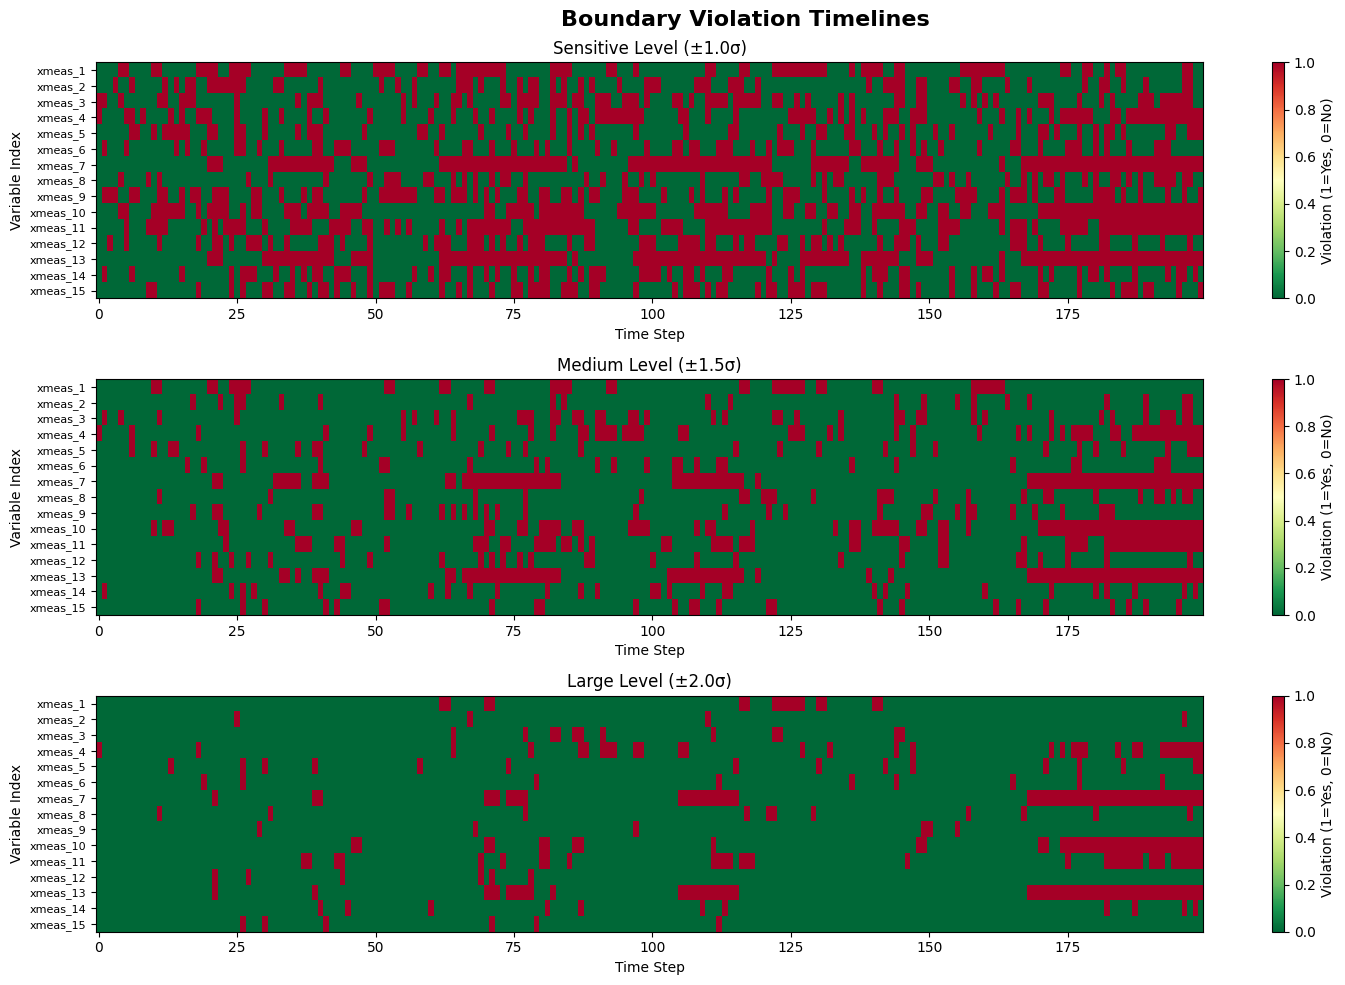

In [20]:
# Generate key visualizations

# 1. Violation timelines
print("Generating violation timelines...")
visualizer.plot_violation_timeline(test_violations, X_OUT_OF_CONTROL_TEST_SELECTED_SCALED, 
                                  n_vars_to_show=15, max_samples=200)

Generating co-occurrence heatmaps...


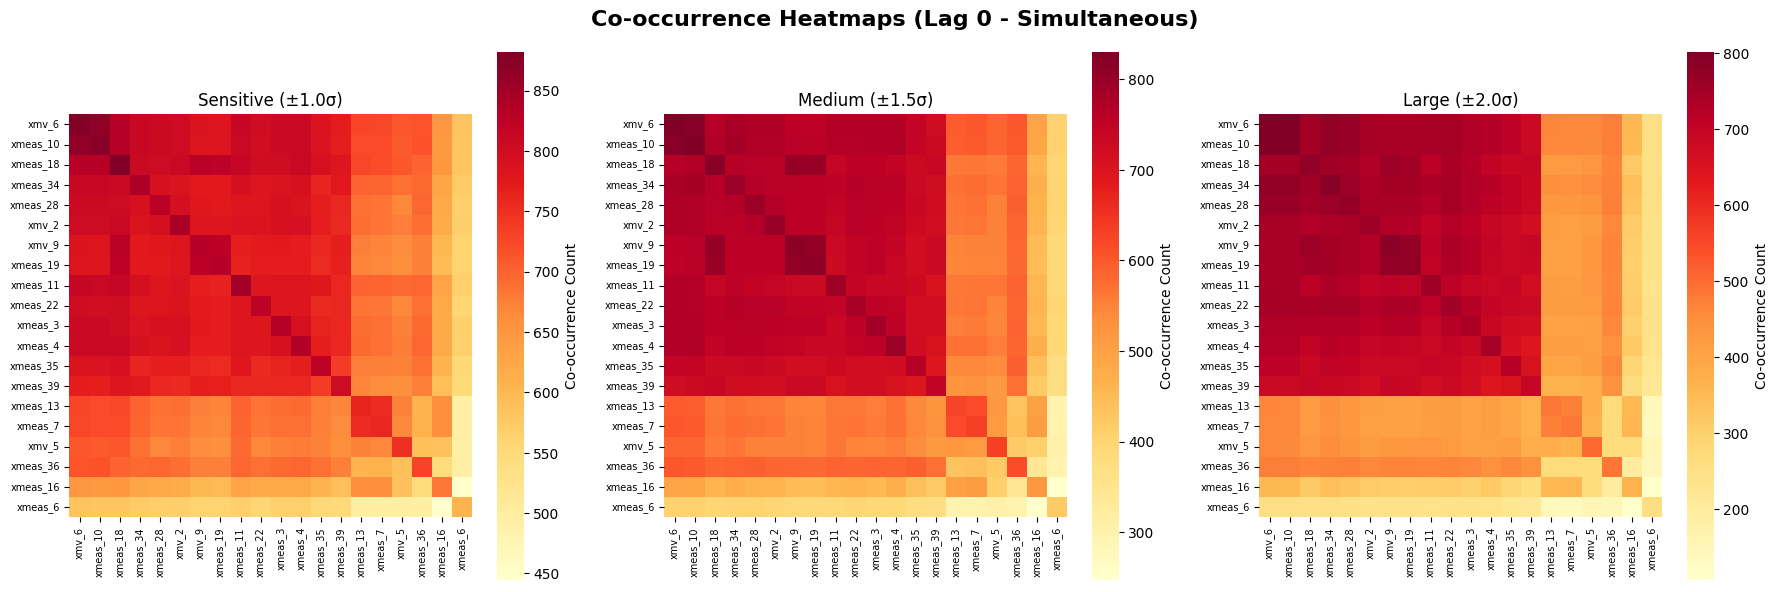

In [21]:
# 2. Co-occurrence heatmaps
print("Generating co-occurrence heatmaps...")
visualizer.plot_cooccurrence_heatmaps(top_n_vars=20)

Generating relationship network graphs...

Sensitive Level Network:


/var/folders/sz/qdyj3ffd5rxg1vjk8d82pkkm0000gp/T/ipykernel_70500/1121606901.py:143: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5,


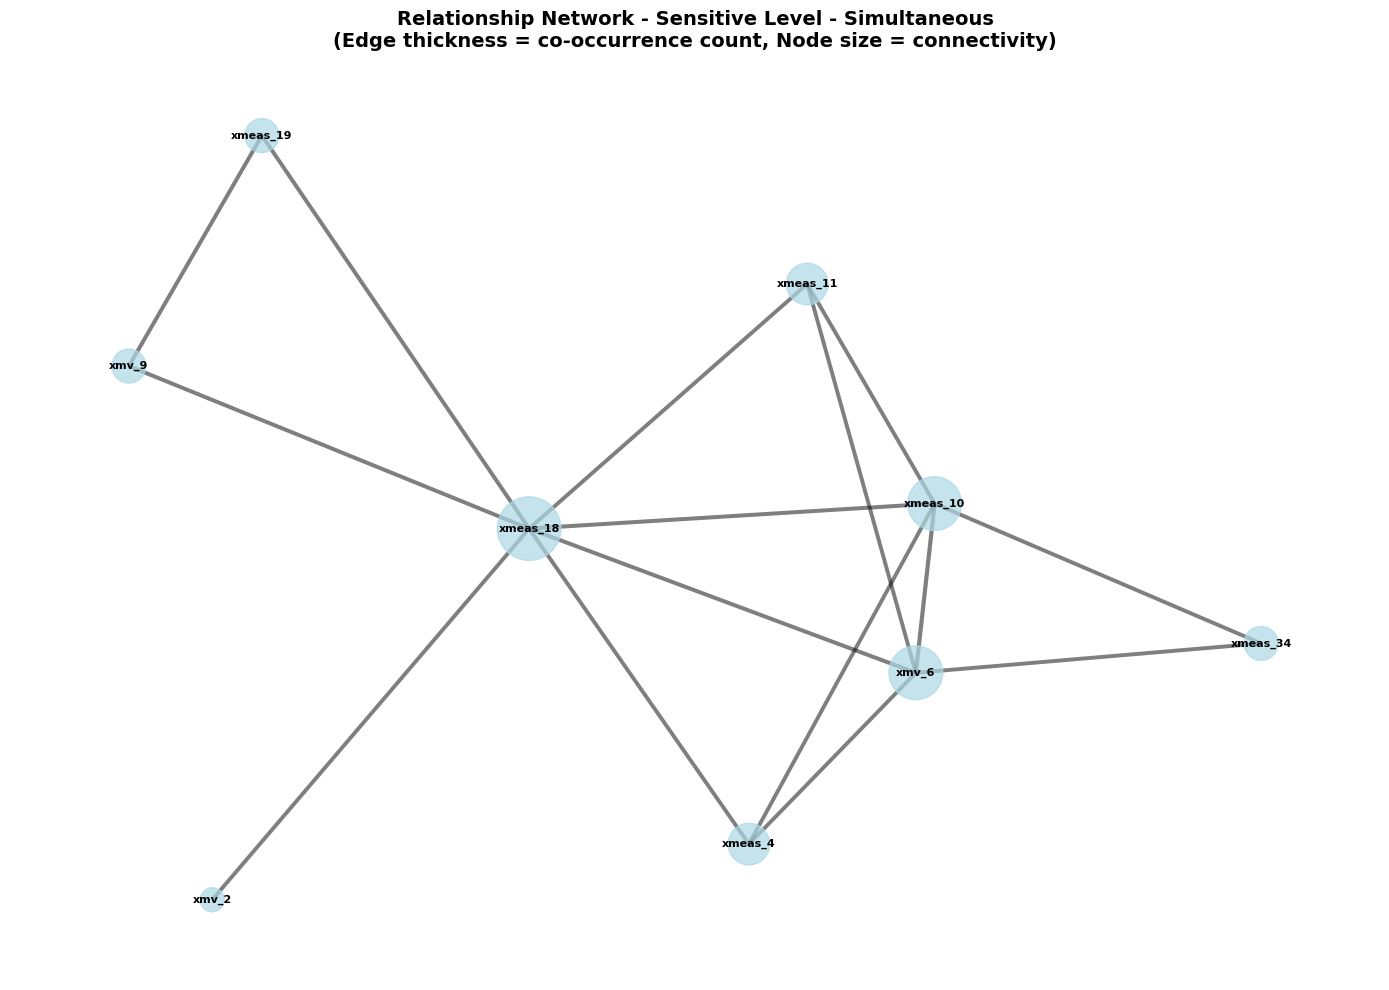


Medium Level Network:


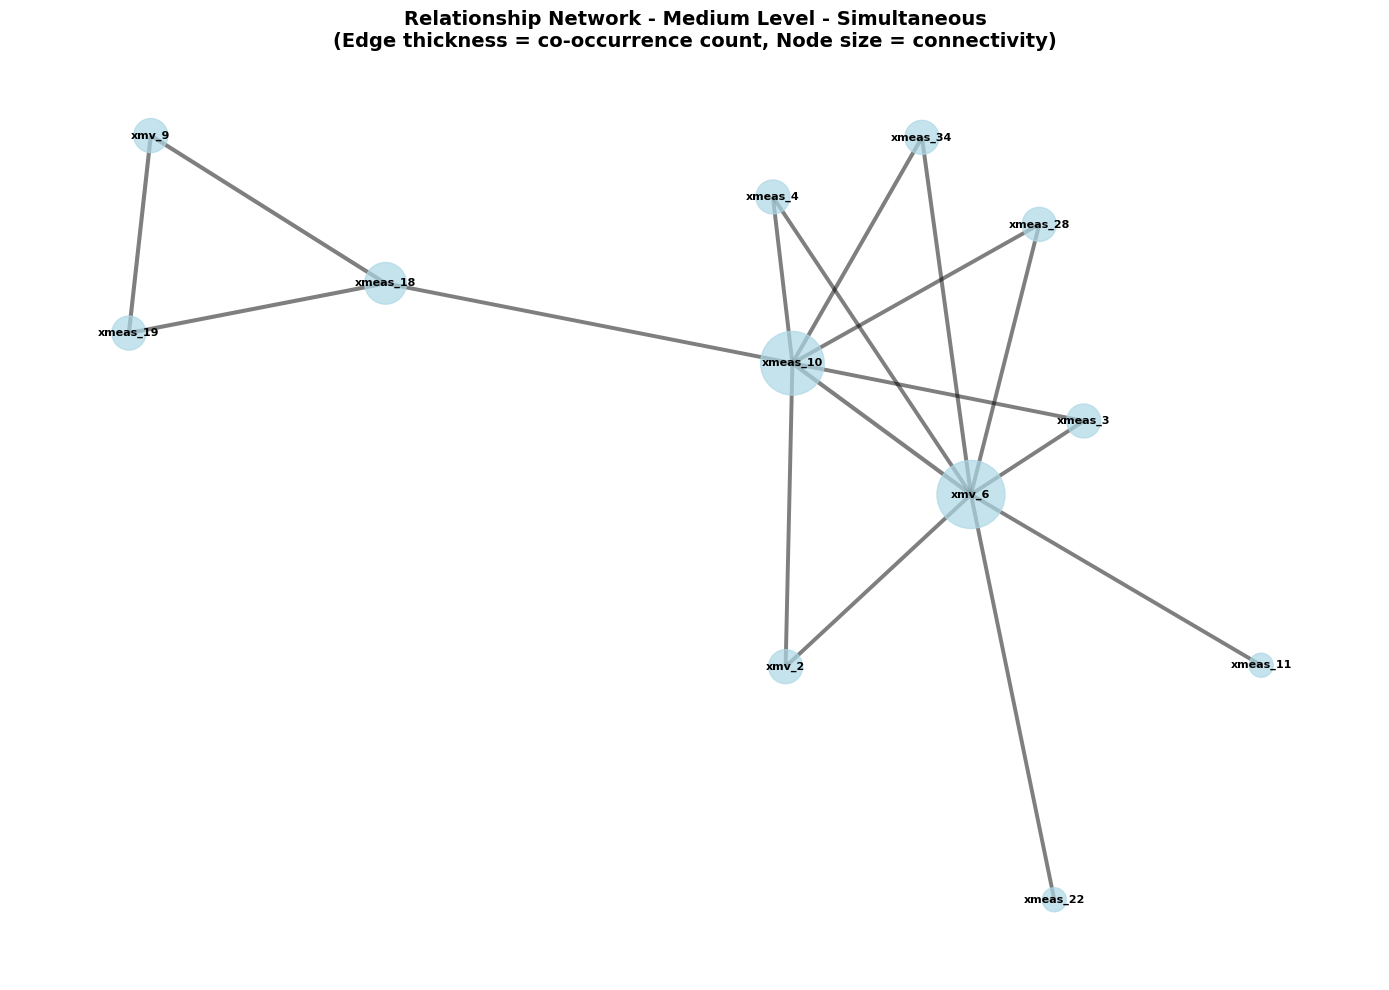


Large Level Network:


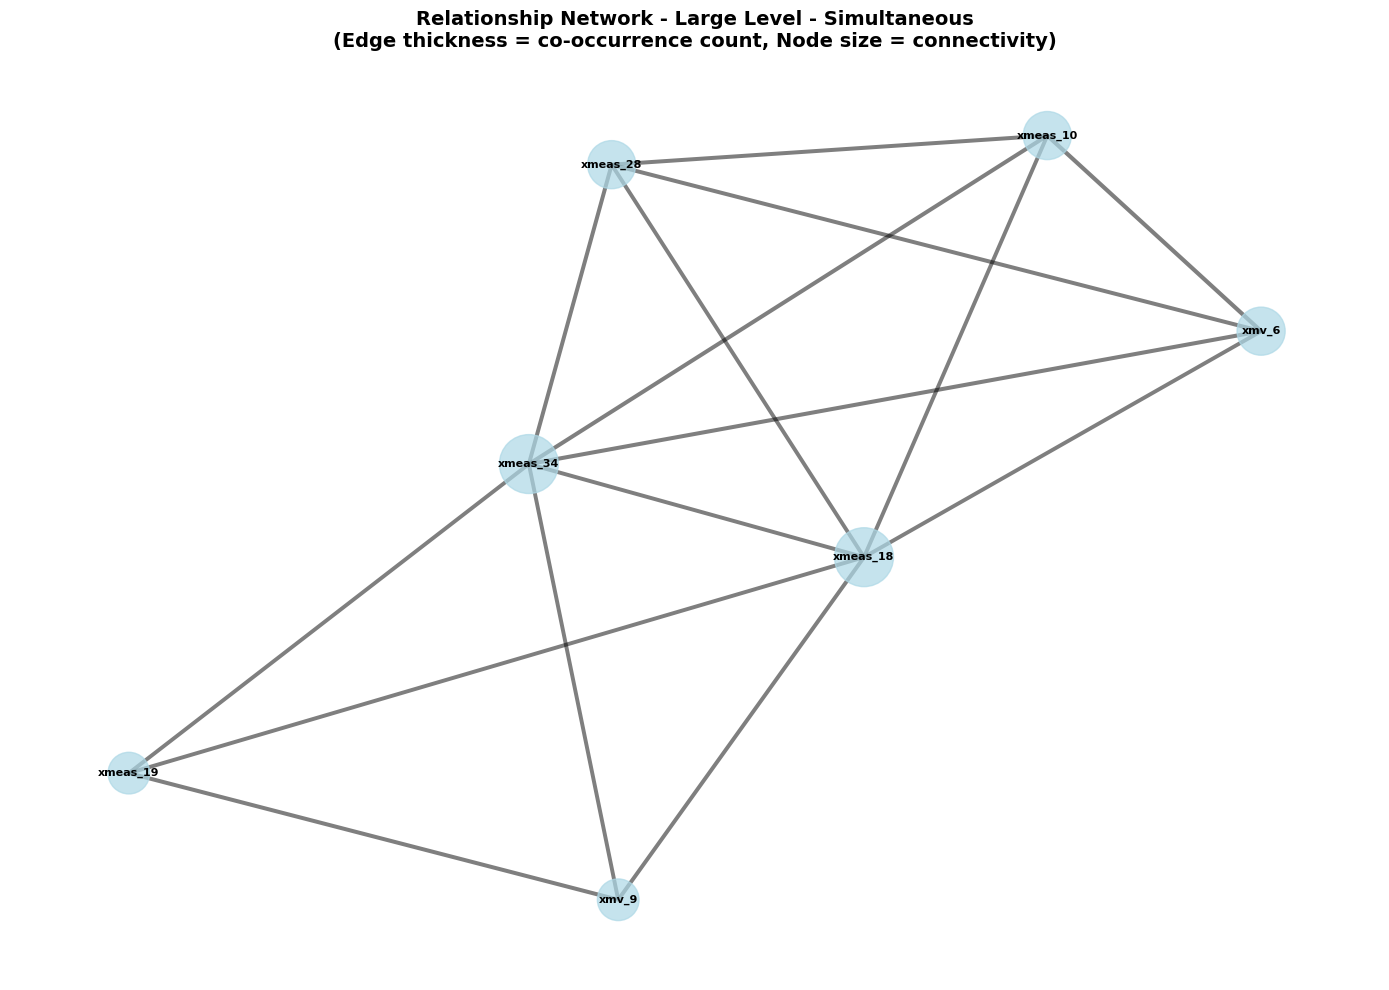

In [22]:
# 3. Relationship network graphs for different sensitivity levels
print("Generating relationship network graphs...")
for level in ['Sensitive', 'Medium', 'Large']:
    print(f"\n{level} Level Network:")
    visualizer.plot_relationship_network(level, lag=0, min_count=50, max_edges=30)

## Online Anomaly Detection System

Implement online monitoring with sliding windows to detect when learned relationships break down.

In [23]:
class OnlineAnomalyDetector:
    """Online anomaly detection using learned relationship baselines"""
    
    def __init__(self, boundary_calc: BoundaryCalculator, 
                 config: AnalysisConfig,
                 baseline_analyzer: CooccurrenceAnalyzer):
        self.boundary_calc = boundary_calc
        self.config = config
        self.baseline_analyzer = baseline_analyzer
        self.window_size = 50  # Sliding window size
        self.anomaly_scores = []
        self.anomaly_details = []
    
    def _compute_baseline_stats(self, level: str) -> Dict:
        """Compute baseline statistics from training phase"""
        stats = {
            'total_relationships': 0,
            'avg_cooccurrence': {},
            'relationship_pairs': set()
        }
        
        if level not in self.baseline_analyzer.lag_relationships:
            return stats
        
        # Collect all relationships and their counts
        all_counts = []
        for lag, rels in self.baseline_analyzer.lag_relationships[level].items():
            stats['total_relationships'] += len(rels)
            for rel in rels:
                pair_key = (rel['var_i'], rel['var_j'], lag)
                stats['relationship_pairs'].add(pair_key)
                stats['avg_cooccurrence'][pair_key] = rel['count']
                all_counts.append(rel['count'])
        
        stats['mean_count'] = np.mean(all_counts) if all_counts else 0
        stats['std_count'] = np.std(all_counts) if all_counts else 1
        
        return stats
    
    def detect_window(self, window_data: np.ndarray, level: str) -> Dict:
        """
        Detect anomalies in a sliding window
        
        Args:
            window_data: Data window (window_size, n_variables)
            level: Sensitivity level to analyze
        
        Returns:
            Dictionary with anomaly scores and details
        """
        # Detect violations in window
        violation_detector = ViolationDetector(self.boundary_calc)
        window_violations = violation_detector.detect(window_data, level)
        
        # Analyze co-occurrence in window
        window_analyzer = CooccurrenceAnalyzer(self.config)
        window_analyzer.analyze_all_lags(window_violations, level)
        
        # Get baseline statistics
        baseline_stats = self._compute_baseline_stats(level)
        
        # Compute anomaly scores
        anomaly_info = {
            'level': level,
            'relationship_deviation': 0,
            'network_structure': 0,
            'excursion_frequency': 0,
            'total_score': 0,
            'details': []
        }
        
        # 1. Relationship deviation score
        if baseline_stats['total_relationships'] > 0:
            deviations = []
            broken_relationships = []
            
            for pair_key, baseline_count in baseline_stats['avg_cooccurrence'].items():
                var_i, var_j, lag = pair_key
                
                # Get current count
                if (level in window_analyzer.cooccurrence_matrices and 
                    lag in window_analyzer.cooccurrence_matrices[level]):
                    current_count = window_analyzer.cooccurrence_matrices[level][lag][var_i, var_j]
                else:
                    current_count = 0
                
                # Calculate deviation (normalized)
                expected = baseline_count
                if expected > 0:
                    deviation = abs(current_count - expected) / (baseline_stats['std_count'] + 1e-6)
                    deviations.append(deviation)
                    
                    # Track significantly broken relationships
                    if current_count < 0.5 * expected and expected > 10:
                        var_i_name = self.config.variable_names[var_i]
                        var_j_name = self.config.variable_names[var_j]
                        broken_relationships.append({
                            'pair': f"{var_i_name} → {var_j_name}",
                            'lag': lag,
                            'expected': expected,
                            'observed': current_count,
                            'deviation': deviation
                        })
            
            anomaly_info['relationship_deviation'] = np.mean(deviations) if deviations else 0
            anomaly_info['details'].extend(broken_relationships[:5])  # Top 5
        
        # 2. Network structure score (unexpected relationships)
        if level in window_analyzer.lag_relationships:
            new_relationships = []
            for lag, rels in window_analyzer.lag_relationships[level].items():
                for rel in rels:
                    pair_key = (rel['var_i'], rel['var_j'], lag)
                    if pair_key not in baseline_stats['relationship_pairs'] and rel['count'] > 5:
                        new_relationships.append({
                            'pair': f"{rel['var_i_name']} → {rel['var_j_name']}",
                            'lag': lag,
                            'count': rel['count'],
                            'type': 'unexpected'
                        })
            
            if new_relationships:
                anomaly_info['network_structure'] = min(len(new_relationships) / 10.0, 1.0)
                anomaly_info['details'].extend(new_relationships[:3])
        
        # 3. Excursion frequency score
        violation_rate = np.sum(window_violations) / (window_violations.shape[0] * window_violations.shape[1])
        expected_rate = 0.05 if level == 'Sensitive' else (0.02 if level == 'Medium' else 0.01)
        anomaly_info['excursion_frequency'] = min(violation_rate / expected_rate, 1.0)
        
        # 4. Total anomaly score (weighted combination)
        anomaly_info['total_score'] = (
            0.4 * min(anomaly_info['relationship_deviation'], 1.0) +
            0.3 * anomaly_info['network_structure'] +
            0.3 * anomaly_info['excursion_frequency']
        )
        
        return anomaly_info
    
    def monitor_stream(self, data: np.ndarray, level: str = 'Sensitive') -> List[Dict]:
        """
        Monitor a data stream with sliding windows
        
        Args:
            data: Full data stream (n_samples, n_variables)
            level: Sensitivity level for monitoring
        
        Returns:
            List of anomaly scores for each window
        """
        n_samples = data.shape[0]
        results = []
        
        for i in range(0, n_samples - self.window_size + 1, self.window_size // 2):
            window = data[i:i+self.window_size, :]
            anomaly_info = self.detect_window(window, level)
            anomaly_info['window_start'] = i
            anomaly_info['window_end'] = i + self.window_size
            results.append(anomaly_info)
        
        return results
    
    def plot_anomaly_scores(self, results: List[Dict]):
        """Plot anomaly scores over time"""
        window_centers = [(r['window_start'] + r['window_end']) / 2 for r in results]
        total_scores = [r['total_score'] for r in results]
        relationship_scores = [r['relationship_deviation'] for r in results]
        network_scores = [r['network_structure'] for r in results]
        excursion_scores = [r['excursion_frequency'] for r in results]
        
        fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
        fig.suptitle('Online Anomaly Detection - Multi-Level Scoring', 
                    fontsize=16, fontweight='bold')
        
        # Total score
        axes[0].plot(window_centers, total_scores, 'b-', linewidth=2)
        axes[0].axhline(y=0.3, color='yellow', linestyle='--', label='Minor')
        axes[0].axhline(y=0.6, color='orange', linestyle='--', label='Moderate')
        axes[0].axhline(y=0.8, color='red', linestyle='--', label='Severe')
        axes[0].set_ylabel('Total Score')
        axes[0].set_title('Overall Anomaly Score')
        axes[0].legend(loc='upper right')
        axes[0].grid(alpha=0.3)
        
        # Component scores
        axes[1].plot(window_centers, relationship_scores, 'g-', linewidth=2)
        axes[1].set_ylabel('Score')
        axes[1].set_title('Relationship Deviation')
        axes[1].grid(alpha=0.3)
        
        axes[2].plot(window_centers, network_scores, 'r-', linewidth=2)
        axes[2].set_ylabel('Score')
        axes[2].set_title('Network Structure Changes')
        axes[2].grid(alpha=0.3)
        
        axes[3].plot(window_centers, excursion_scores, 'm-', linewidth=2)
        axes[3].set_ylabel('Score')
        axes[3].set_title('Excursion Frequency')
        axes[3].set_xlabel('Sample Index')
        axes[3].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def generate_alert_report(self, results: List[Dict], threshold: float = 0.6):
        """Generate report of detected anomalies"""
        print("\n" + "=" * 80)
        print("ANOMALY DETECTION ALERT REPORT")
        print("=" * 80)
        
        alerts = [r for r in results if r['total_score'] >= threshold]
        
        print(f"\nTotal windows analyzed: {len(results)}")
        print(f"Anomalies detected (score >= {threshold}): {len(alerts)}")
        
        if alerts:
            print(f"\n\nDETAILED ANOMALY REPORTS:")
            print("-" * 80)
            
            for i, alert in enumerate(alerts, 1):
                score = alert['total_score']
                severity = ('SEVERE' if score >= 0.8 else 
                          'MODERATE' if score >= 0.6 else 'MINOR')
                
                print(f"\n\n{i}. Window [{alert['window_start']}-{alert['window_end']}] - {severity}")
                print(f"   Total Score: {score:.3f}")
                print(f"   Relationship Deviation: {alert['relationship_deviation']:.3f}")
                print(f"   Network Structure: {alert['network_structure']:.3f}")
                print(f"   Excursion Frequency: {alert['excursion_frequency']:.3f}")
                
                if alert['details']:
                    print(f"\n   Key Issues:")
                    for detail in alert['details']:
                        if 'expected' in detail:
                            print(f"     • Broken: {detail['pair']} (lag {detail['lag']})")
                            print(f"       Expected: {detail['expected']:.1f}, Observed: {detail['observed']:.1f}")
                        elif 'type' in detail and detail['type'] == 'unexpected':
                            print(f"     • New: {detail['pair']} (lag {detail['lag']}, count {detail['count']})")
        else:
            print("\nNo significant anomalies detected.")
        
        print("\n" + "=" * 80)

# Initialize online detector with baseline from in-control training data
online_detector = OnlineAnomalyDetector(boundary_calc, config, cooccurrence_analyzer)

print("Online anomaly detector initialized with baseline from training data.")

Online anomaly detector initialized with baseline from training data.


Running online anomaly detection on out-of-control test data...
This compares test data against the baseline learned from in-control training data.



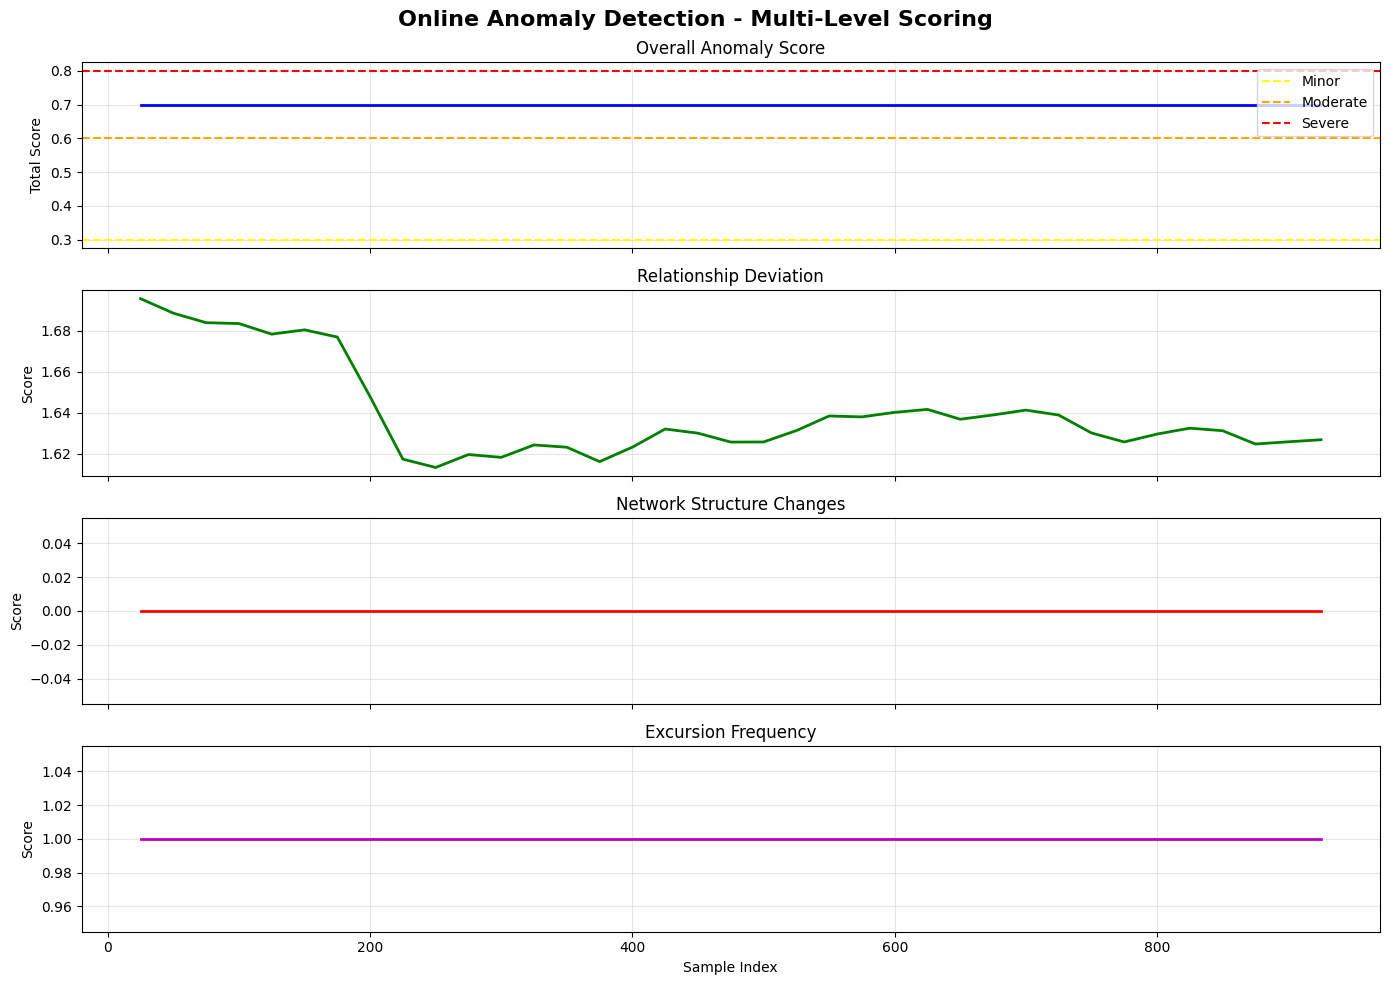


ANOMALY DETECTION ALERT REPORT

Total windows analyzed: 37
Anomalies detected (score >= 0.5): 37


DETAILED ANOMALY REPORTS:
--------------------------------------------------------------------------------


1. Window [0-50] - MODERATE
   Total Score: 0.700
   Relationship Deviation: 1.696
   Network Structure: 0.000
   Excursion Frequency: 1.000

   Key Issues:
     • Broken: xmeas_10 → xmv_6 (lag 0)
       Expected: 866.0, Observed: 23.0
     • Broken: xmv_6 → xmeas_10 (lag 0)
       Expected: 866.0, Observed: 23.0
     • Broken: xmeas_10 → xmeas_18 (lag 0)
       Expected: 833.0, Observed: 6.0
     • Broken: xmeas_18 → xmeas_10 (lag 0)
       Expected: 833.0, Observed: 6.0
     • Broken: xmeas_18 → xmv_6 (lag 0)
       Expected: 833.0, Observed: 4.0


2. Window [25-75] - MODERATE
   Total Score: 0.700
   Relationship Deviation: 1.688
   Network Structure: 0.000
   Excursion Frequency: 1.000

   Key Issues:
     • Broken: xmeas_10 → xmv_6 (lag 0)
       Expected: 866.0, Observed: 14

In [24]:
# Run online monitoring on out-of-control test data
print("Running online anomaly detection on out-of-control test data...")
print("This compares test data against the baseline learned from in-control training data.\n")

# Monitor at Sensitive level for early warnings
monitoring_results = online_detector.monitor_stream(
    X_OUT_OF_CONTROL_TEST_SELECTED_SCALED, 
    level='Sensitive'
)

# Plot anomaly scores
online_detector.plot_anomaly_scores(monitoring_results)

# Generate alert report
online_detector.generate_alert_report(monitoring_results, threshold=0.5)

## Summary and Usage Guide

### Complete System Implemented

This notebook now contains a fully functional **Multivariate Relationship Discovery System** with:

#### Offline Analysis (Training Phase)
1. **BoundaryCalculator** - Defines normal operating boundaries at multiple sensitivity levels (1σ, 1.5σ, 2σ)
2. **ViolationDetector** - Detects when variables exceed boundaries
3. **CooccurrenceAnalyzer** - Discovers relationships with lag detection (0 to 10 timesteps)
4. **RelationshipReporter** - Generates comprehensive reports organized by sensitivity level
5. **RelationshipVisualizer** - Creates timelines, heatmaps, and network graphs

#### Online Monitoring (Detection Phase)
6. **OnlineAnomalyDetector** - Real-time anomaly detection using sliding windows
   - Detects relationship breakdowns
   - Identifies unexpected new relationships
   - Monitors excursion frequency
   - Provides multi-level scoring and alerts

### Key Features
- **No variable filtering** - ALL 52 variables analyzed at ALL sensitivity levels
- **Hierarchical refinement** - Captures robust, moderate, and sensitive relationships
- **Time-lag awareness** - Discovers delayed dependencies between variables
- **Interpretable** - Based on simple boundary violations, not complex statistics
- **Actionable** - Robust relationships for critical alarms, sensitive ones for early warnings

### Usage Examples

```python
# Customize configuration
config.sensitive_sigma = 0.8  # More sensitive
config.max_lag = 15           # Check longer time delays

# Analyze different data
boundary_calc.fit(new_training_data)
test_violations = violation_detector.detect_all_levels(new_test_data)
cooccurrence_analyzer.analyze_all_lags(test_violations['Sensitive'], 'Sensitive')

# Generate reports
reporter.generate_full_report()

# Visualize specific relationships
visualizer.plot_lag_distribution(var_i=0, var_j=5, level='Sensitive')
visualizer.plot_relationship_network('Medium', lag=0, min_count=20)

# Online monitoring
monitoring_results = online_detector.monitor_stream(streaming_data, level='Medium')
online_detector.plot_anomaly_scores(monitoring_results)
online_detector.generate_alert_report(monitoring_results, threshold=0.6)
```

### Next Steps
- Run the cells above to see the system in action
- Experiment with different sensitivity levels and lag ranges
- Compare in-control vs out-of-control data
- Use for fault diagnosis in Tennessee Eastman Process

## Variable Distribution Analysis

Visualize the distribution of each variable with Gaussian curves and boundary markers at all sensitivity levels.

In [25]:
from scipy import stats

class DistributionVisualizer:
    """Visualize variable distributions with boundaries"""
    
    def __init__(self, boundary_calc: BoundaryCalculator, config: AnalysisConfig):
        self.boundary_calc = boundary_calc
        self.config = config
    
    def plot_variable_distribution(self, var_idx: int, data: np.ndarray, 
                                   test_data: np.ndarray = None):
        """
        Plot distribution for a single variable with histogram, Gaussian curve, and boundaries
        
        Args:
            var_idx: Variable index to plot
            data: Training data used to calculate boundaries
            test_data: Optional test data to overlay
        """
        var_name = self.config.variable_names[var_idx]
        var_data = data[:, var_idx]
        
        # Get statistics
        mean = self.boundary_calc.means[var_idx]
        std = self.boundary_calc.stds[var_idx]
        
        # Create figure
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
        # Plot histogram of training data
        counts, bins, patches = ax.hist(var_data, bins=50, density=True, 
                                        alpha=0.6, color='steelblue', 
                                        edgecolor='black', linewidth=0.5,
                                        label='Training Data')
        
        # Plot test data histogram if provided
        if test_data is not None:
            test_var_data = test_data[:, var_idx]
            ax.hist(test_var_data, bins=50, density=True, 
                   alpha=0.4, color='coral', 
                   edgecolor='black', linewidth=0.5,
                   label='Test Data (Out-of-Control)')
        
        # Plot Gaussian curve
        x_range = np.linspace(var_data.min(), var_data.max(), 300)
        gaussian = stats.norm.pdf(x_range, mean, std)
        ax.plot(x_range, gaussian, 'k-', linewidth=2.5, label='Gaussian Fit')
        
        # Get y-axis limits for boundary lines
        y_max = ax.get_ylim()[1]
        
        # Plot boundaries for each sensitivity level with different colors
        colors = {'Sensitive': 'red', 'Medium': 'orange', 'Large': 'green'}
        line_styles = {'Sensitive': '--', 'Medium': '-.', 'Large': ':'}
        
        for level in ['Sensitive', 'Medium', 'Large']:
            lower, upper = self.boundary_calc.get_boundaries(level)
            sigma = self.config.sensitivity_levels[level]
            color = colors[level]
            linestyle = line_styles[level]
            
            # Plot lower boundary
            ax.axvline(lower[var_idx], color=color, linestyle=linestyle, 
                      linewidth=2, alpha=0.8)
            
            # Plot upper boundary
            ax.axvline(upper[var_idx], color=color, linestyle=linestyle, 
                      linewidth=2, alpha=0.8,
                      label=f'{level} (±{sigma}σ)')
            
            # Add shaded regions for boundaries
            ax.axvspan(lower[var_idx], upper[var_idx], 
                      alpha=0.05, color=color)
        
        # Plot mean line
        ax.axvline(mean, color='black', linestyle='-', linewidth=2, 
                  alpha=0.5, label='Mean')
        
        # Labels and title
        ax.set_xlabel('Standardized Value', fontsize=12, fontweight='bold')
        ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
        ax.set_title(f'Distribution Analysis: {var_name} (Variable {var_idx})\n' +
                    f'Mean={mean:.3f}, Std={std:.3f}',
                    fontsize=14, fontweight='bold')
        
        # Legend
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(alpha=0.3, linestyle=':', linewidth=0.5)
        
        # Add text box with boundary widths
        boundary_info = f"Boundary Widths:\n"
        for level in ['Sensitive', 'Medium', 'Large']:
            lower, upper = self.boundary_calc.get_boundaries(level)
            width = upper[var_idx] - lower[var_idx]
            boundary_info += f"  {level}: {width:.3f}\n"
        
        ax.text(0.02, 0.98, boundary_info,
               transform=ax.transAxes,
               fontsize=9,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
    
    def plot_all_variables(self, data: np.ndarray, test_data: np.ndarray = None,
                          n_cols: int = 3, variables_to_plot: list = None):
        """
        Plot distributions for multiple variables in a grid
        
        Args:
            data: Training data
            test_data: Optional test data
            n_cols: Number of columns in grid
            variables_to_plot: List of variable indices to plot (None = all)
        """
        if variables_to_plot is None:
            variables_to_plot = list(range(len(self.config.variable_names)))
        
        n_vars = len(variables_to_plot)
        n_rows = (n_vars + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
        fig.suptitle('Variable Distribution Analysis with Multi-Level Boundaries', 
                    fontsize=16, fontweight='bold')
        
        # Flatten axes for easier iteration
        if n_rows == 1 and n_cols == 1:
            axes = [axes]
        else:
            axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
        
        colors = {'Sensitive': 'red', 'Medium': 'orange', 'Large': 'green'}
        line_styles = {'Sensitive': '--', 'Medium': '-.', 'Large': ':'}
        
        for idx, var_idx in enumerate(variables_to_plot):
            ax = axes[idx]
            var_name = self.config.variable_names[var_idx]
            var_data = data[:, var_idx]
            
            # Get statistics
            mean = self.boundary_calc.means[var_idx]
            std = self.boundary_calc.stds[var_idx]
            
            # Plot histogram
            ax.hist(var_data, bins=30, density=True, 
                   alpha=0.6, color='steelblue', 
                   edgecolor='black', linewidth=0.3)
            
            # Plot test data if provided
            if test_data is not None:
                test_var_data = test_data[:, var_idx]
                ax.hist(test_var_data, bins=30, density=True, 
                       alpha=0.4, color='coral', 
                       edgecolor='black', linewidth=0.3)
            
            # Plot Gaussian curve
            x_range = np.linspace(var_data.min(), var_data.max(), 100)
            gaussian = stats.norm.pdf(x_range, mean, std)
            ax.plot(x_range, gaussian, 'k-', linewidth=1.5)
            
            # Plot boundaries
            for level in ['Sensitive', 'Medium', 'Large']:
                lower, upper = self.boundary_calc.get_boundaries(level)
                color = colors[level]
                linestyle = line_styles[level]
                
                ax.axvline(lower[var_idx], color=color, linestyle=linestyle, 
                          linewidth=1.5, alpha=0.7)
                ax.axvline(upper[var_idx], color=color, linestyle=linestyle, 
                          linewidth=1.5, alpha=0.7)
            
            # Mean line
            ax.axvline(mean, color='black', linestyle='-', linewidth=1, alpha=0.5)
            
            # Labels
            ax.set_title(f'{var_name}\n(μ={mean:.2f}, σ={std:.2f})', 
                        fontsize=9, fontweight='bold')
            ax.set_xlabel('Value', fontsize=8)
            ax.set_ylabel('Density', fontsize=8)
            ax.tick_params(labelsize=7)
            ax.grid(alpha=0.2, linestyle=':', linewidth=0.5)
        
        # Hide empty subplots
        for idx in range(len(variables_to_plot), len(axes)):
            axes[idx].axis('off')
        
        # Add legend to the figure
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], color='steelblue', lw=4, alpha=0.6, label='Training Data'),
            Line2D([0], [0], color='coral', lw=4, alpha=0.6, label='Test Data'),
            Line2D([0], [0], color='black', lw=2, label='Gaussian Fit'),
            Line2D([0], [0], color='black', lw=2, alpha=0.5, label='Mean'),
            Line2D([0], [0], color='red', lw=2, linestyle='--', label='Sensitive (±1σ)'),
            Line2D([0], [0], color='orange', lw=2, linestyle='-.', label='Medium (±1.5σ)'),
            Line2D([0], [0], color='green', lw=2, linestyle=':', label='Large (±2σ)')
        ]
        fig.legend(handles=legend_elements, loc='upper center', 
                  bbox_to_anchor=(0.5, 0.98), ncol=7, fontsize=10)
        
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()

# Initialize distribution visualizer
dist_visualizer = DistributionVisualizer(boundary_calc, config)

print("Distribution visualizer initialized.")

Distribution visualizer initialized.


Detailed distribution plot for Variable 0:


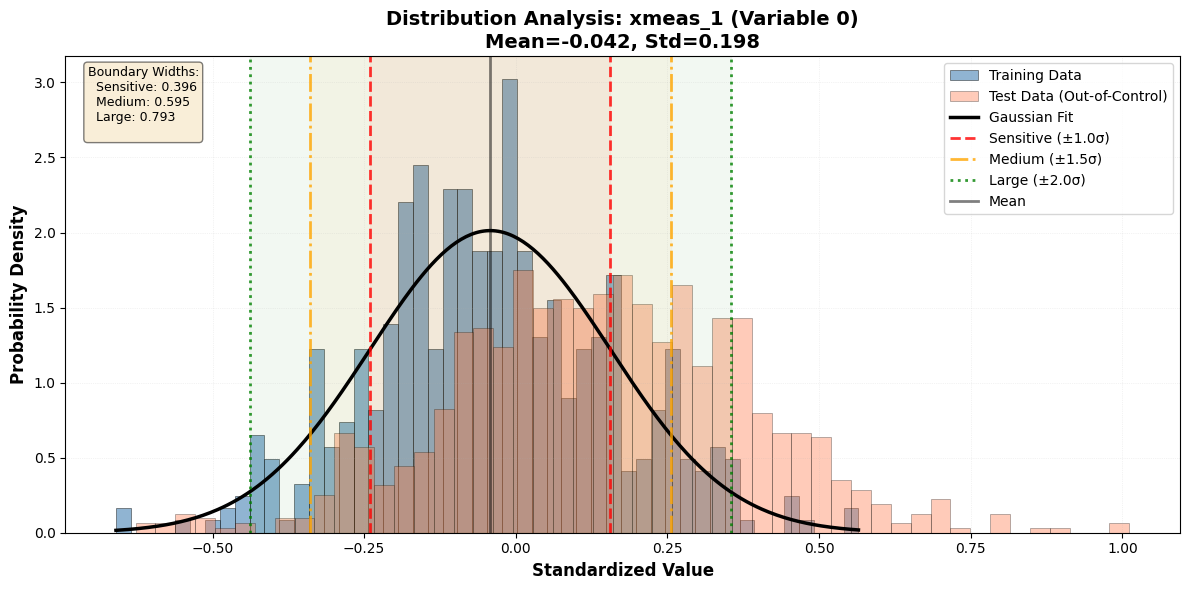

In [26]:
# Example 1: Plot detailed distribution for a single variable
print("Detailed distribution plot for Variable 0:")
dist_visualizer.plot_variable_distribution(
    var_idx=0, 
    data=X_INCONTROL_TRAIN_SELECTED_SCALED,
    test_data=X_OUT_OF_CONTROL_TEST_SELECTED_SCALED
)

Plotting detailed distributions for first 5 variables...

Variable 0: xmeas_1


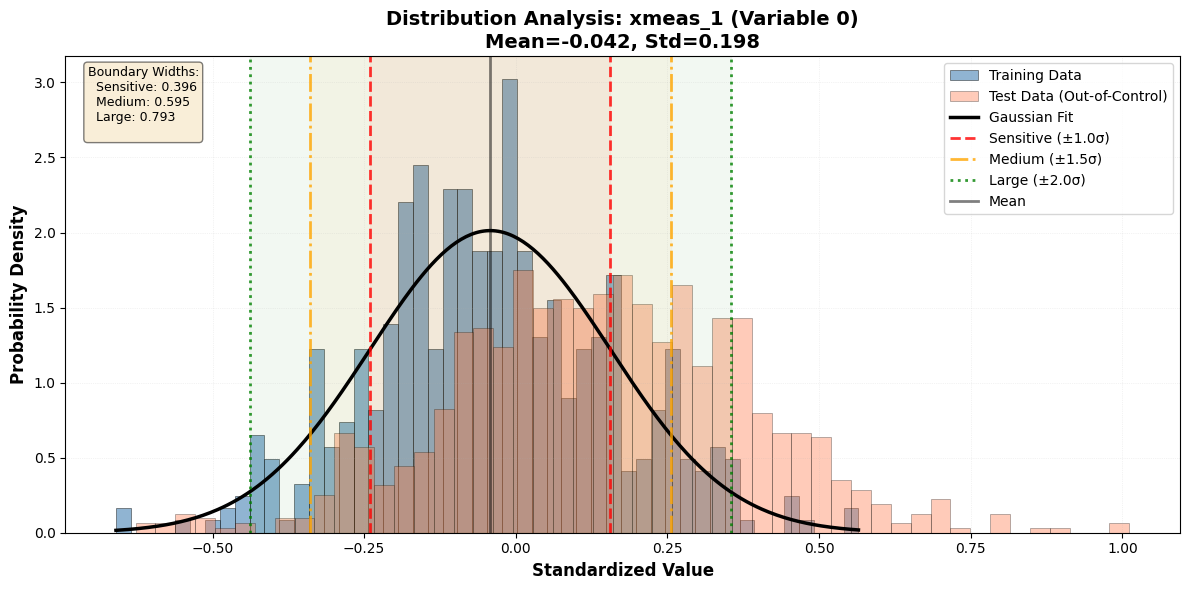


Variable 1: xmeas_2


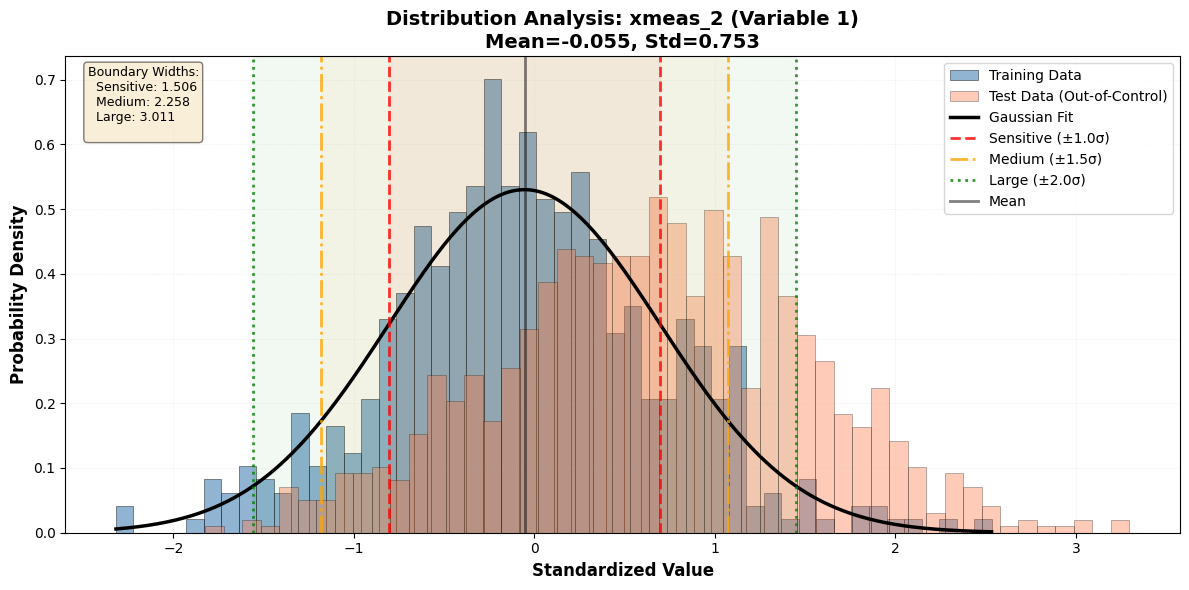


Variable 2: xmeas_3


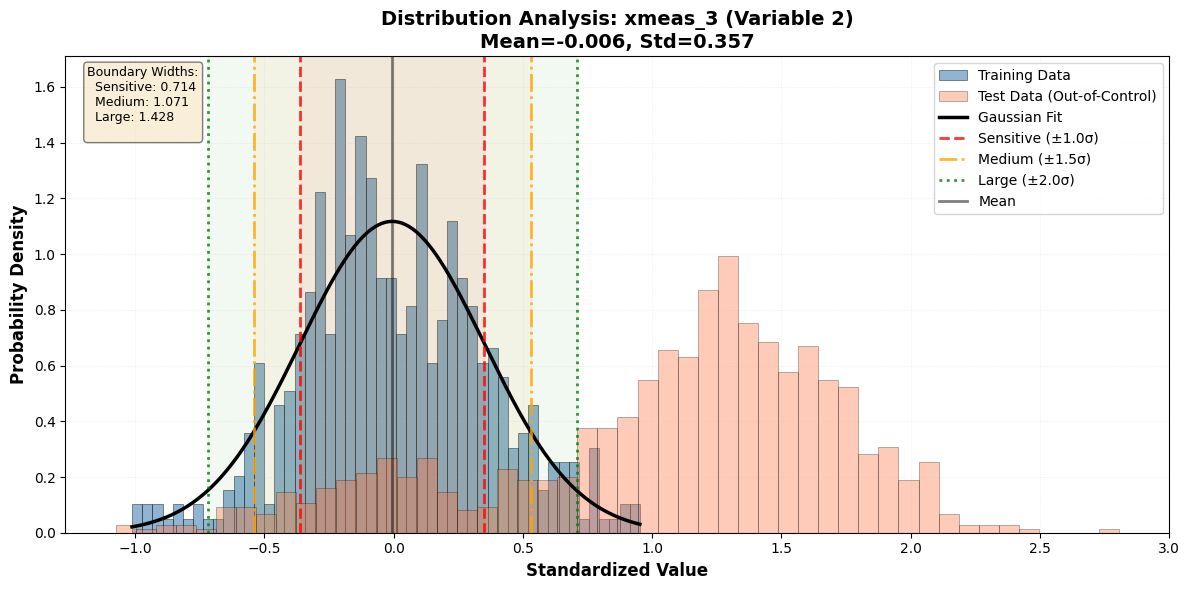


Variable 3: xmeas_4


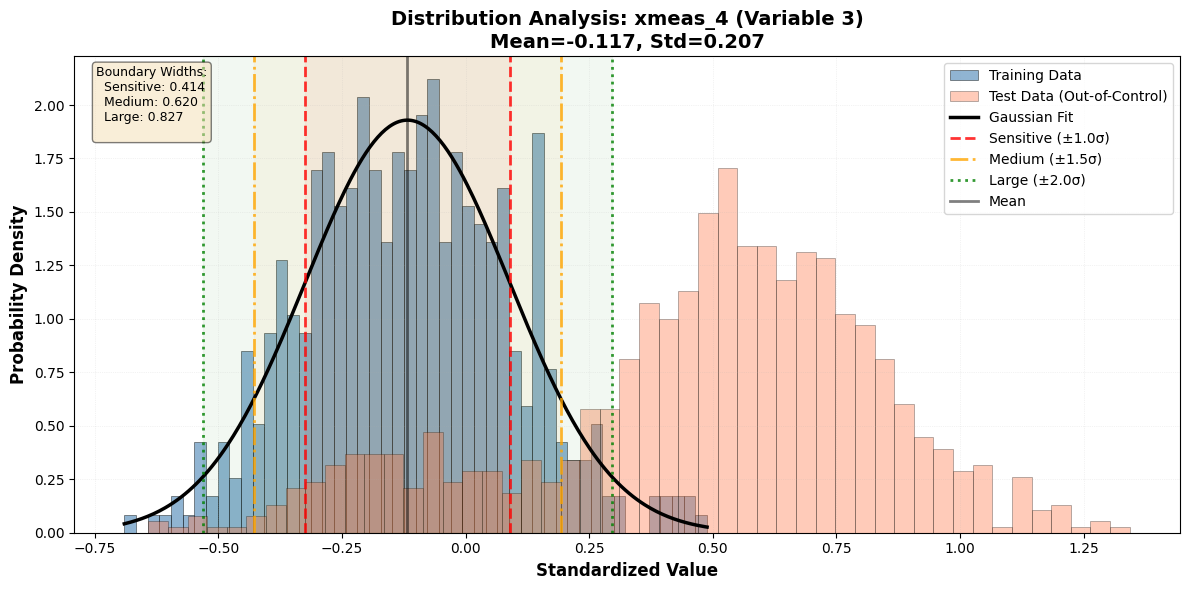


Variable 4: xmeas_5


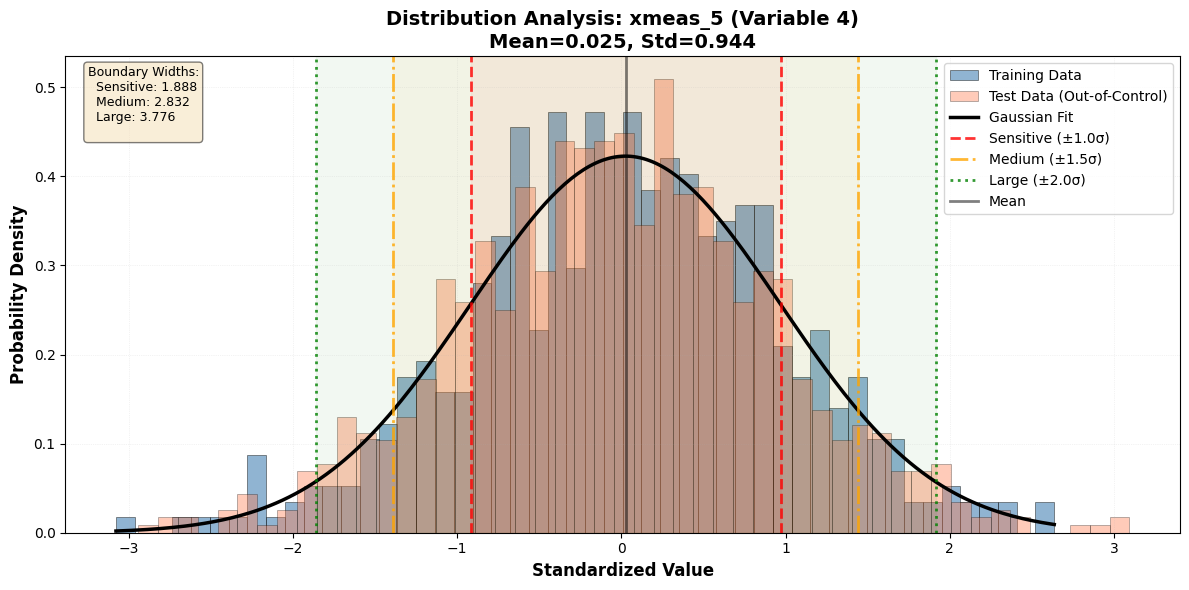

In [27]:
# Example 2: Plot detailed distributions for first 5 variables individually
print("Plotting detailed distributions for first 5 variables...")
for i in range(5):
    print(f"\nVariable {i}: {config.variable_names[i]}")
    dist_visualizer.plot_variable_distribution(
        var_idx=i, 
        data=X_INCONTROL_TRAIN_SELECTED_SCALED,
        test_data=X_OUT_OF_CONTROL_TEST_SELECTED_SCALED
    )

Plotting all 52 variables in grid layout...


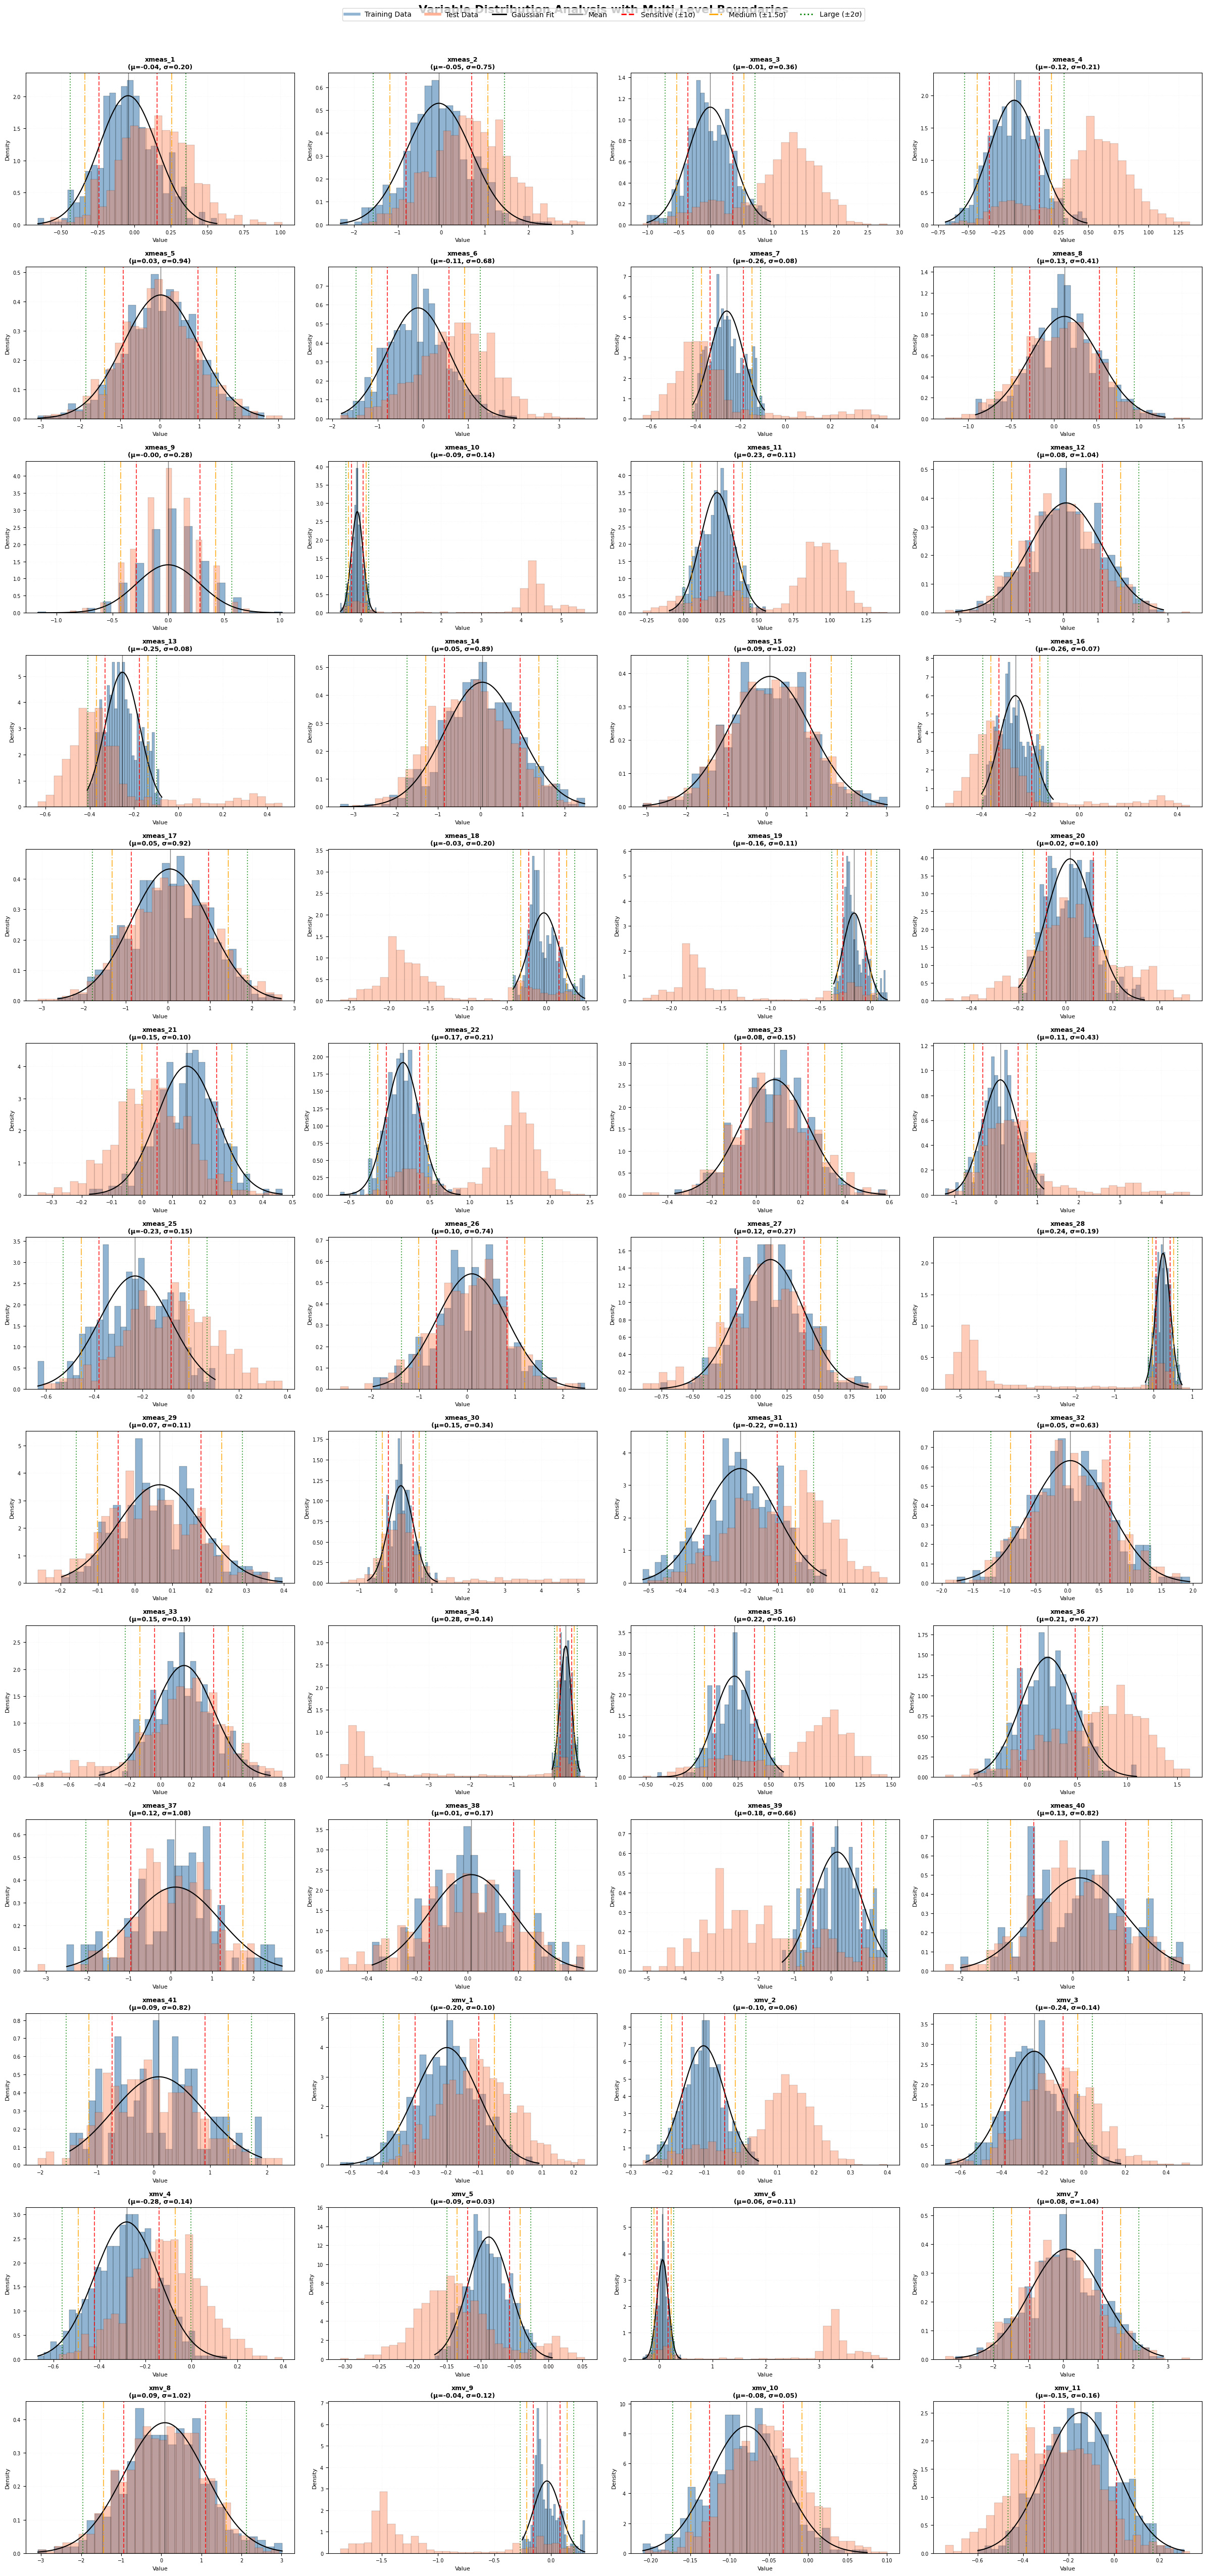

In [28]:
# Example 3: Plot all 52 variables in a grid view
print("Plotting all 52 variables in grid layout...")
dist_visualizer.plot_all_variables(
    data=X_INCONTROL_TRAIN_SELECTED_SCALED,
    test_data=X_OUT_OF_CONTROL_TEST_SELECTED_SCALED,
    n_cols=4
)

Plotting selected variables...


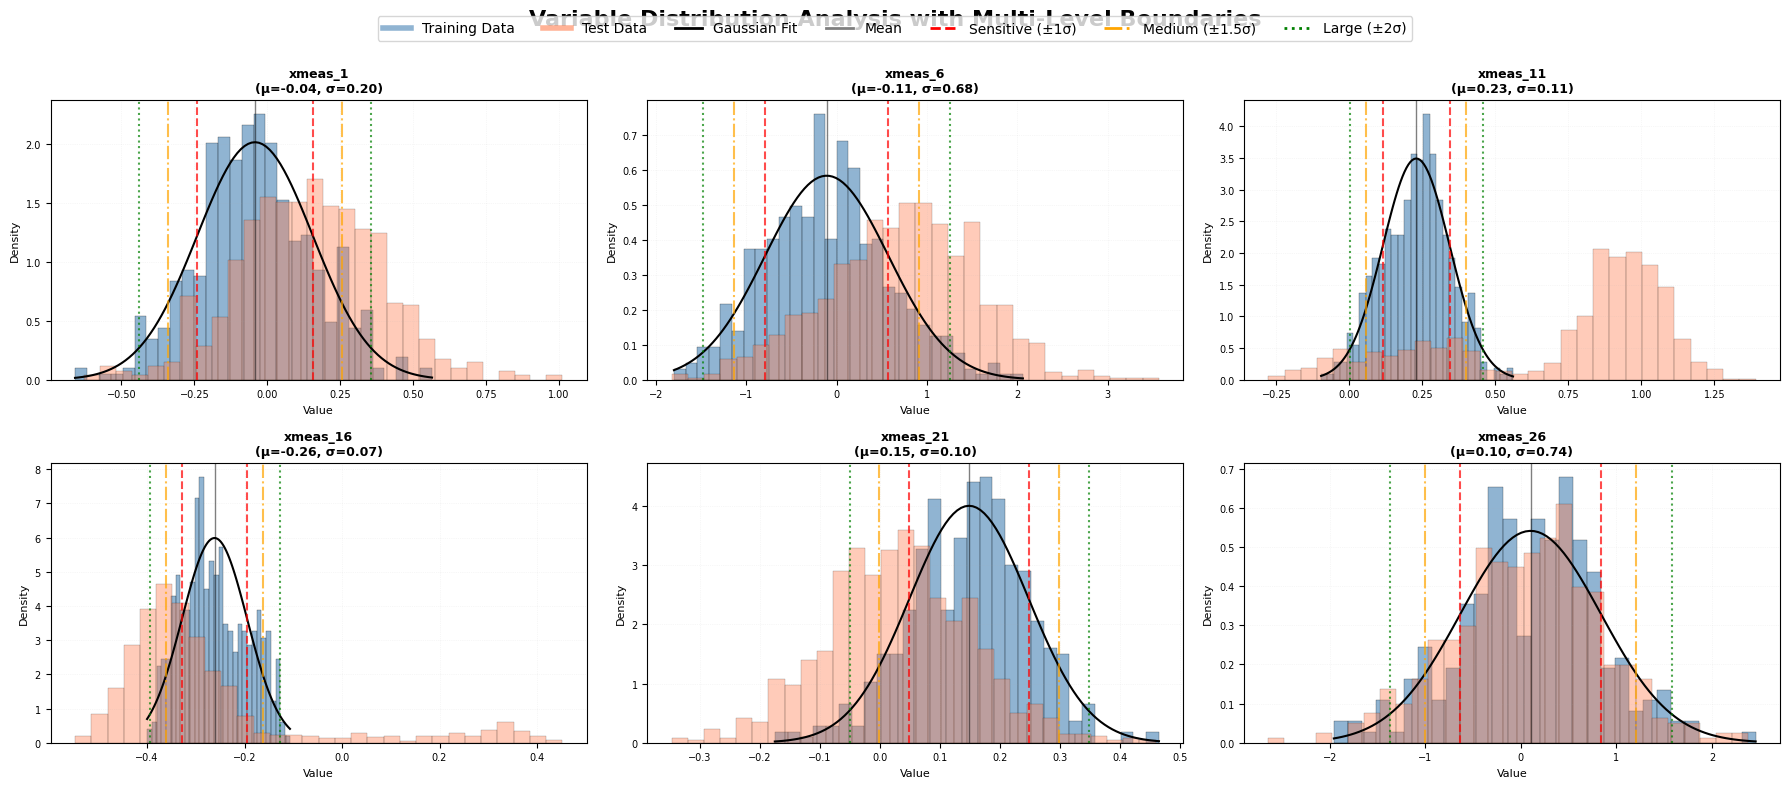

In [29]:
# Example 4: Plot specific variables of interest
print("Plotting selected variables...")
variables_of_interest = [0, 5, 10, 15, 20, 25]  # Customize this list
dist_visualizer.plot_all_variables(
    data=X_INCONTROL_TRAIN_SELECTED_SCALED,
    test_data=X_OUT_OF_CONTROL_TEST_SELECTED_SCALED,
    n_cols=3,
    variables_to_plot=variables_of_interest
)